In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 12.6 MB/s eta 0:00:00


# XGB

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.ndimage import gaussian_filter1d
import logging

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Loading data
df = pd.read_csv('/content/final_data_exchange_bias.csv')
df = df.drop(columns=['core', 'shell', 'formula'])

# Dictionary for renaming columns
rename_dict = {
    'area/volume': 'Area to volume ratio',
    'h_range_max_koe': 'Maximum field range',
    'Tc': 'Curie temperature',
    'temperature_k': 'Experimental temperature',
    'sat_em_g': 'Saturation magnetization',
    'coer_oe': 'Coercivity',
    'mr (emu/g)': 'Remanent magnetization',
    'exc_bias_oe': 'Exchange bias shift',
    'exc_dir': 'Exchange shift direction',
    'ver_shift_emu_g': 'Vertical shift',
    'ver_s_dir': 'Vertical shift direction',
    'fc_field_t': 'Magnetic field strength',
    'sphericity': 'Sphericity',
    'max/min': 'Geometric anisotropy',
    'core_b': 'Core b lattice parameter',
    'core_alpha': 'Core alpha angle',
    'core_beta': 'Core beta angle',
    'core_gamma': 'Core gamma angle',
    'shell_b': 'Shell b lattice parameter',
    'shell_alpha': 'Shell alpha angle',
    'shell_beta': 'Shell beta angle',
    'shell_gamma': 'Shell gamma angle',
    'num_of_magn_ions': 'Magnetic ion ratio',
    'Tn-Tb/Tn': 'Temperature difference',
    'Aex': 'Exchange stiffness coefficient',
    'core_c/a': 'Core lattice ratio с to a',
    'core_pauling_electronegativity': 'Pauling electronegativity of core',
    'shell_pauling_electronegativity': 'Pauling electronegativity of shell',
    'core_sum_vec': 'Valence electron concentration of core',
    'core_sum_work_function': 'Work function of core',
    'shell_sum_vec': 'Valence electron concentration of shell',
    'shell_sum_work_function': 'Work function of shell',
    'core_pauling_electronegativity_difference': 'Pauling electronegativity difference of core',
    'core_vec_difference': 'Valence electron concentration difference of core',
    'core_work_function_difference': 'Work function difference of core',
    'shell_pauling_electronegativity_difference': 'Pauling electronegativity difference of shell',
    'shell_vec_difference': 'Valence electron concentration difference of shell',
    'shell_work_function_difference': 'Work function difference of shell'
}

# Renaming columns
df = df.rename(columns=rename_dict)

In [ ]:
# Preprocessing
y = df['Exchange bias shift']
y = y[y > 0]  # Filter only positive values
y_smooth = gaussian_filter1d(y, sigma=2)

# Log transformation of the smoothed target variable
y_log = np.log10(y_smooth)

In [ ]:
# Feature selection
X = df[df['Exchange bias shift'] > 0].drop(columns=['Exchange bias shift'])

# Applying KNN Imputer to fill missing values
knn_imputer = KNNImputer(n_neighbors=5)
X_imputed = knn_imputer.fit_transform(X)

# Convert the imputed array back into a DataFrame and ensure the renamed columns are used
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

In [ ]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed_df, y_log, test_size=0.2, random_state=1984)

# Scaling the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames with the same column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## SHAP for XGB

In [ ]:
# Defining models with specified hyperparameters
models = {
    'XGB': XGBRegressor(n_estimators=424, max_depth=22, learning_rate=0.029775486467142665,
                          subsample=0.7358573421632647, colsample_bytree=0.5128835927539236, gamma=0.001178216687382395,
                          reg_alpha=0.3688362981967942, reg_lambda=0.9581849266893232, min_child_weight=4,
                          scale_pos_weight=9.787498596663324, random_state=1984)
}

Training XGB...


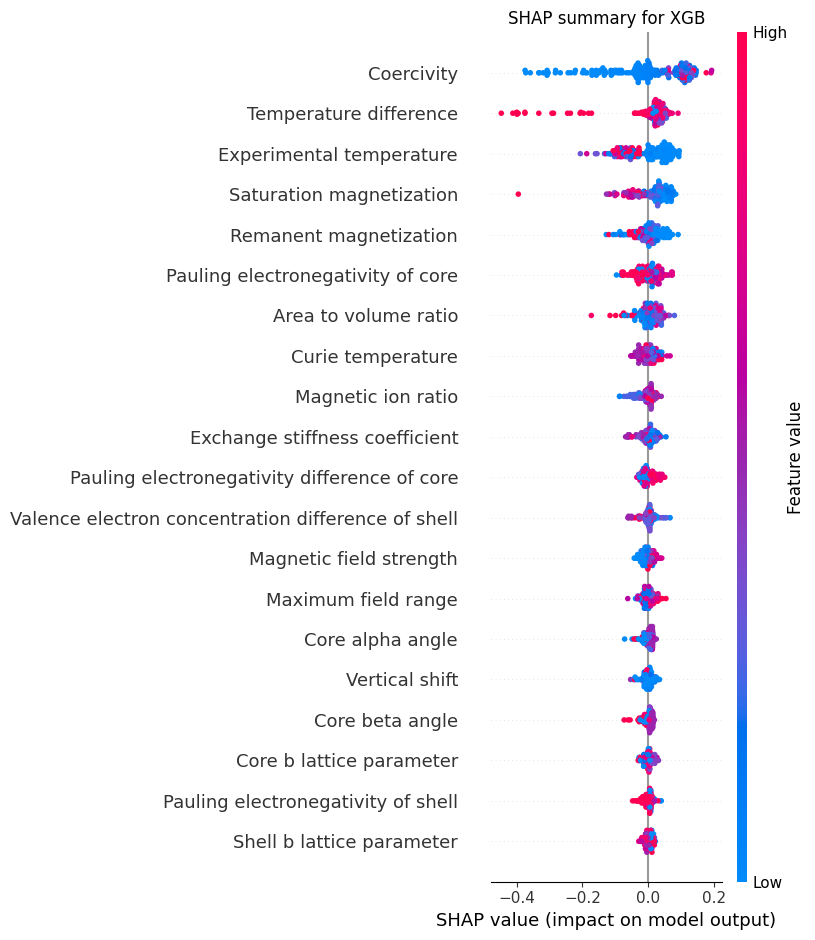

In [ ]:
# Training models and generating SHAP plots
shap_values = {}
explainer = {}

for name, model in models.items():
    print(f'Training {name}...')
    model.fit(X_train_scaled_df, y_train)

    # Using TreeExplainer for tree-based models
    if name.startswith(('ExtraTrees', 'RandomForest', 'GradientBoosting', 'HistGradientBoosting', 'XGB', 'LGBM')):
        explainer[name] = shap.TreeExplainer(model)
        shap_values[name] = explainer[name].shap_values(X_test_scaled_df)
    else:
        # Using KernelExplainer for Bagging Regressor
        explainer[name] = shap.KernelExplainer(model.predict, X_train_scaled_df[:50])  # Use a small sample for speed
        shap_values[name] = explainer[name].shap_values(X_test_scaled_df)

    # Plot SHAP summary for top 6 most important features
    plt.title(f'SHAP summary for {name}')
    shap.summary_plot(shap_values[name], X_test_scaled_df)
    plt.show()

In [ ]:
# Getting top 10 most important features by SHAP
shap_importance = np.abs(shap_values['XGB']).mean(axis=0)  # Average absolute values of SHAP
important_features_idx = np.argsort(shap_importance)[-10:]  # Top 10 Feature Indexes
important_features = X_test_scaled_df.columns[important_features_idx]  # Names top 10 features
print(f'Top 10 most important features by SHAP for XGB: {important_features}')

Top 10 most important features by SHAP for XGB: Index(['Exchange stiffness coefficient', 'Magnetic ion ratio',
       'Curie temperature', 'Area to volume ratio',
       'Pauling electronegativity of core', 'Remanent magnetization',
       'Saturation magnetization', 'Experimental temperature',
       'Temperature difference', 'Coercivity'],
      dtype='object')


## Compare 25% predicted values of XGB

In [ ]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

<ipython-input-10-f42c23aff0e8>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-10-f42c23aff0e8>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


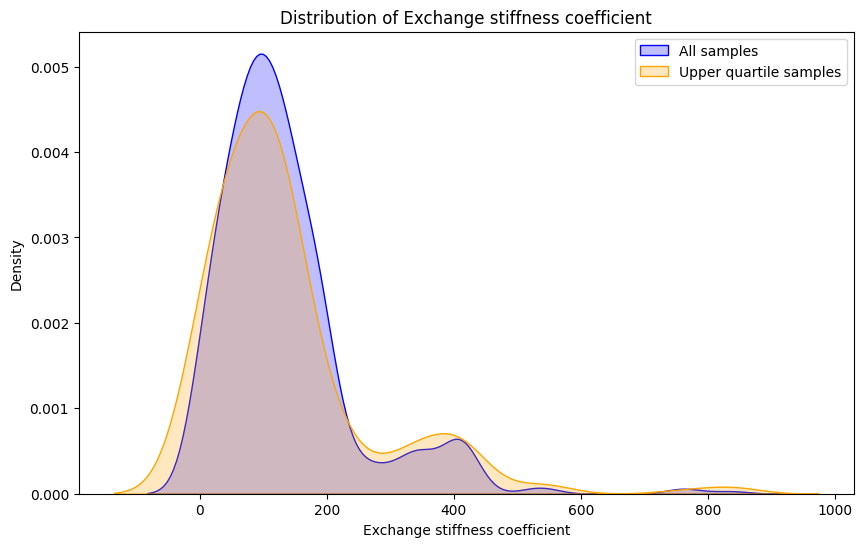

Mann-Whitney U test for Exchange stiffness coefficient: statistic=114205.5000, p-value=0.2475


<ipython-input-10-f42c23aff0e8>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-10-f42c23aff0e8>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


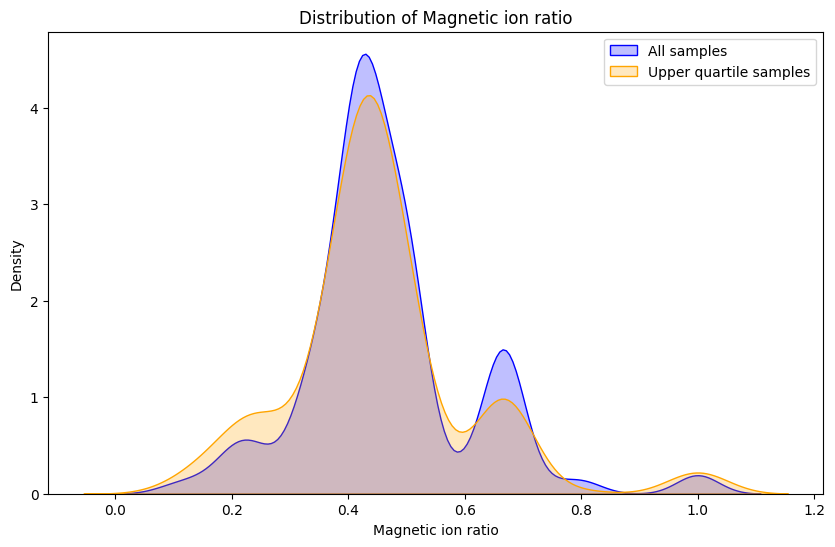

Mann-Whitney U test for Magnetic ion ratio: statistic=114691.5000, p-value=0.2866


<ipython-input-10-f42c23aff0e8>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-10-f42c23aff0e8>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


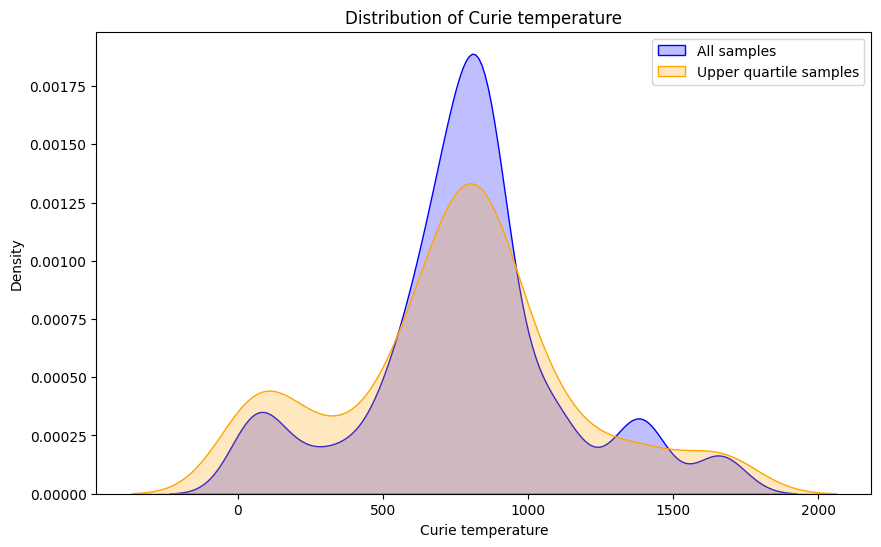

Mann-Whitney U test for Curie temperature: statistic=115823.0000, p-value=0.4066


<ipython-input-10-f42c23aff0e8>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-10-f42c23aff0e8>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


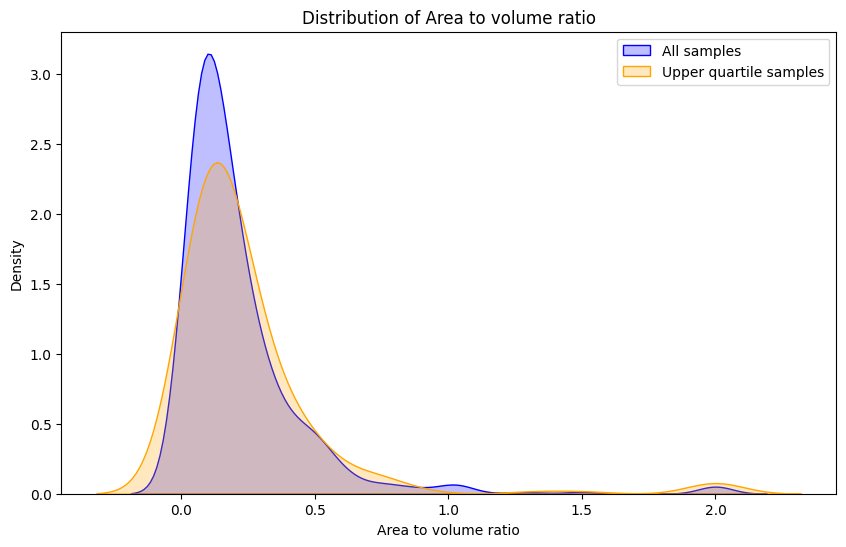

Mann-Whitney U test for Area to volume ratio: statistic=126916.0000, p-value=0.1578


<ipython-input-10-f42c23aff0e8>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-10-f42c23aff0e8>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


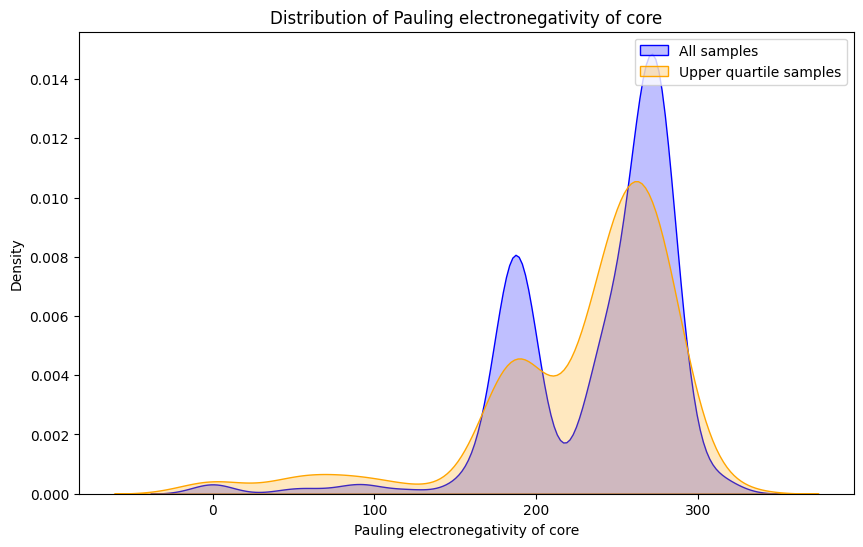

Mann-Whitney U test for Pauling electronegativity of core: statistic=107975.5000, p-value=0.0155


<ipython-input-10-f42c23aff0e8>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-10-f42c23aff0e8>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


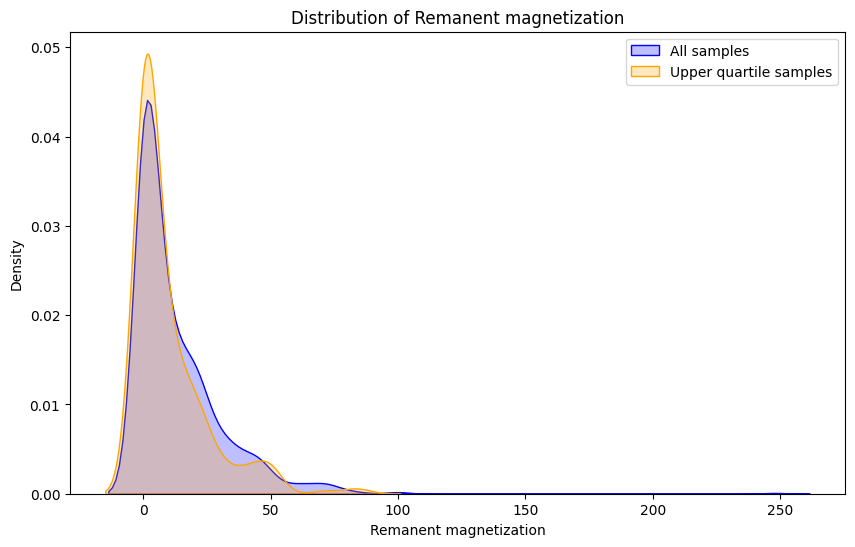

Mann-Whitney U test for Remanent magnetization: statistic=107592.5000, p-value=0.0127


<ipython-input-10-f42c23aff0e8>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-10-f42c23aff0e8>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


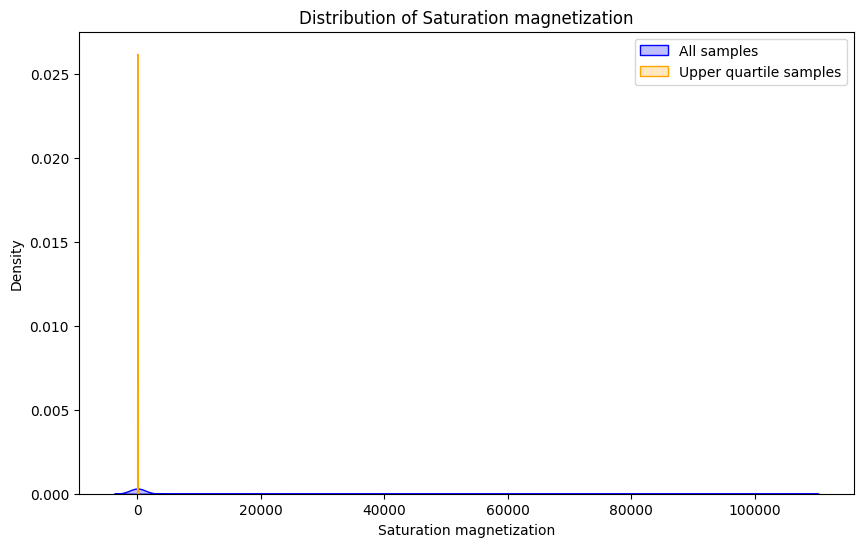

Mann-Whitney U test for Saturation magnetization: statistic=90963.5000, p-value=0.0000


<ipython-input-10-f42c23aff0e8>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-10-f42c23aff0e8>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


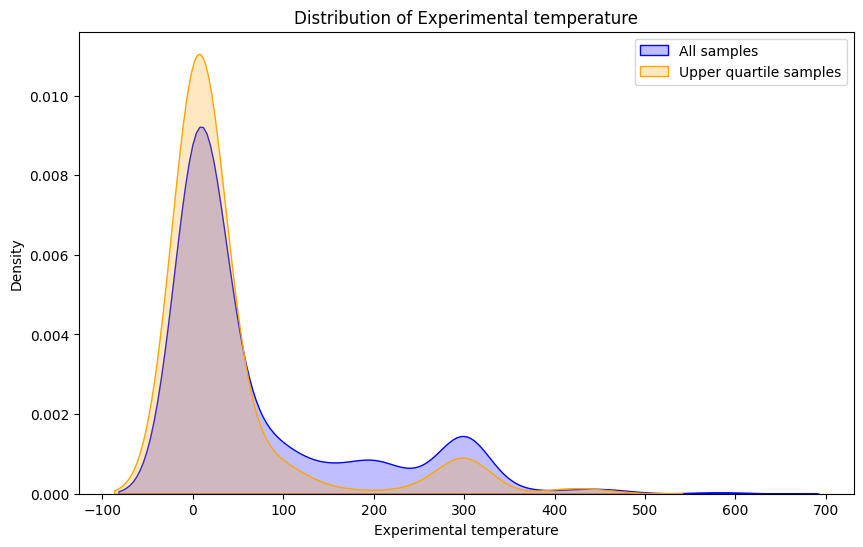

Mann-Whitney U test for Experimental temperature: statistic=92987.5000, p-value=0.0000


<ipython-input-10-f42c23aff0e8>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-10-f42c23aff0e8>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


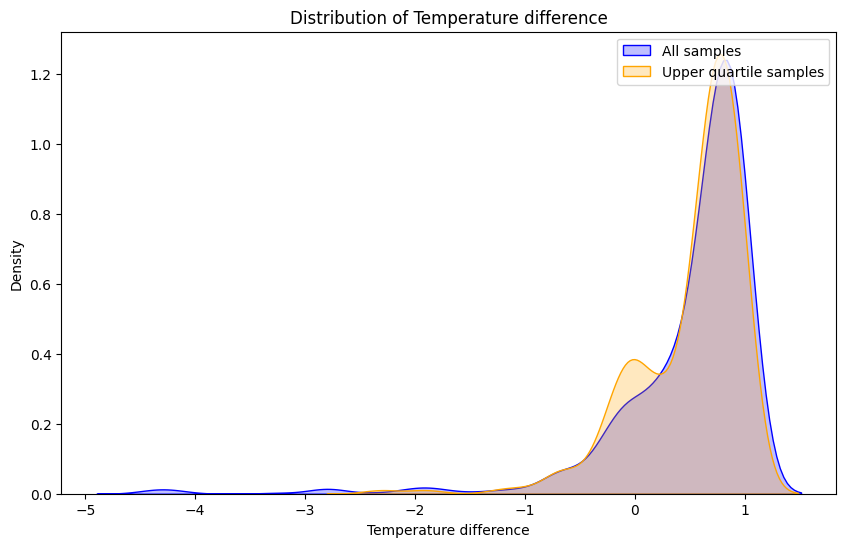

Mann-Whitney U test for Temperature difference: statistic=109963.0000, p-value=0.0440


<ipython-input-10-f42c23aff0e8>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-10-f42c23aff0e8>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


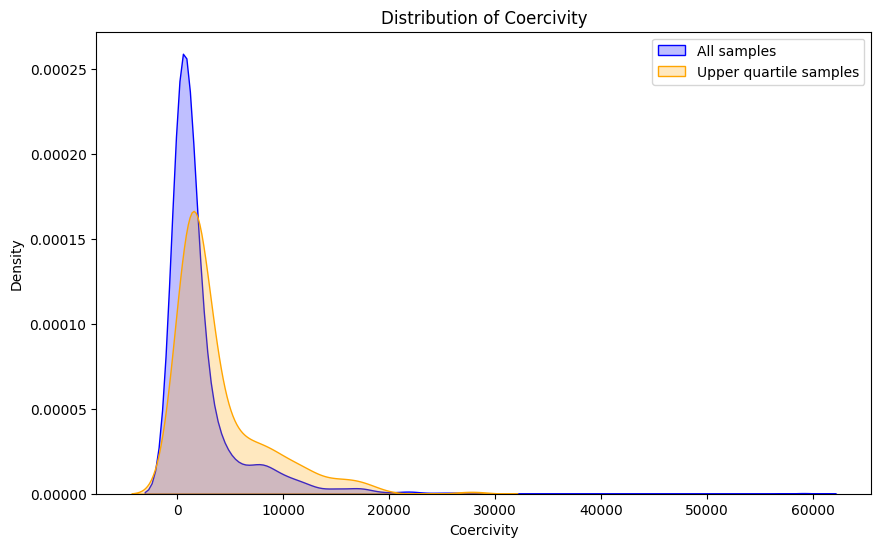

Mann-Whitney U test for Coercivity: statistic=170045.0000, p-value=0.0000


In [ ]:
# Select the samples with the greatest displacements (upper quartile)
upper_quartile_threshold = np.percentile(y, 75)
large_eb_shift_samples = df[df['Exchange bias shift'] >= upper_quartile_threshold]

#  Source and top quartile by target variable
y_upper_quartile = y[y >= upper_quartile_threshold]
X_upper_quartile = X[df['Exchange bias shift'] >= upper_quartile_threshold]

# Function for constructing distributions and the Mann-Witney test
def plot_feature_comparison(feature):
    # Get data for the upper quartile and all others
    data_upper = X_upper_quartile[feature]
    data_all = df[feature]

    # Distribution visualization
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
    sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Mann-Witney statistical test
    stat, p_value = stats.mannwhitneyu(data_upper, data_all)
    print(f'Mann-Whitney U test for {feature}: statistic={stat:.4f}, p-value={p_value:.4f}')

# For each important topic for KAN we build charts and run a statistical test
for feature in important_features:
    plot_feature_comparison(feature)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


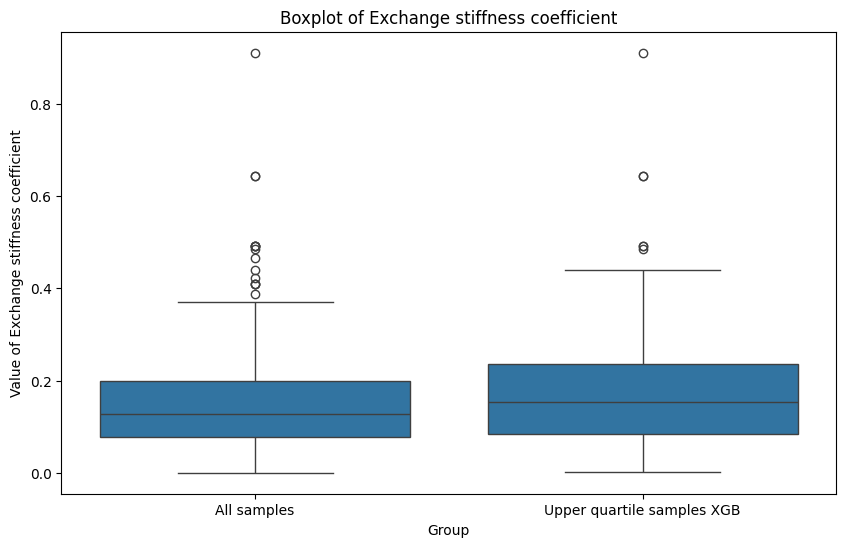

Mann-Whitney U test for Exchange stiffness coefficient: statistic=5290.5000, p-value=0.2714


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


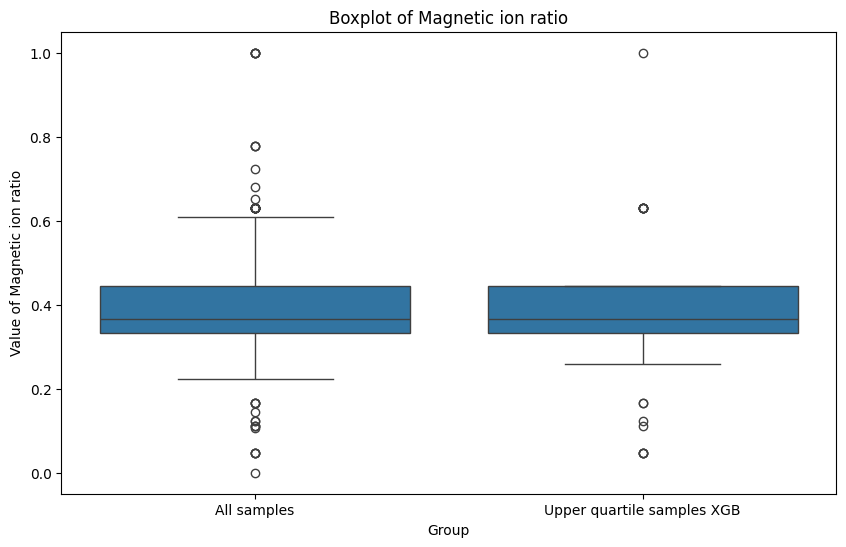

Mann-Whitney U test for Magnetic ion ratio: statistic=4739.5000, p-value=0.8882


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


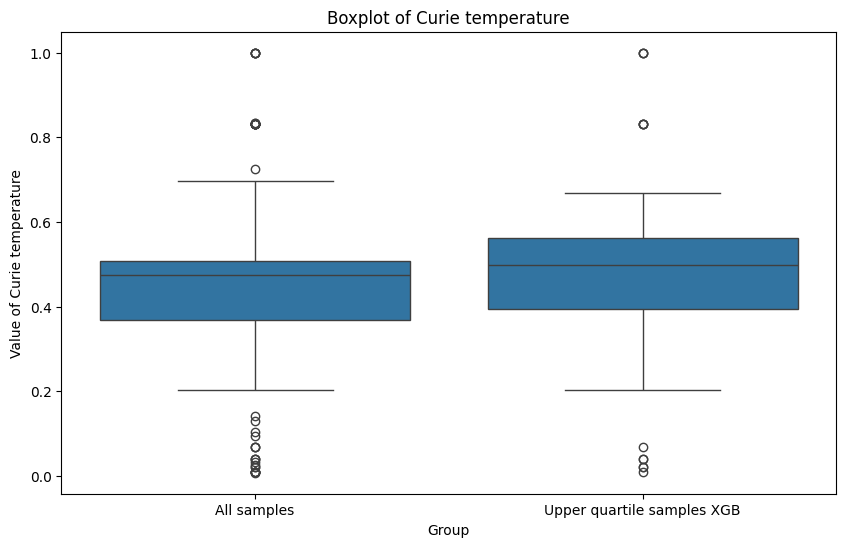

Mann-Whitney U test for Curie temperature: statistic=5152.5000, p-value=0.4298


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


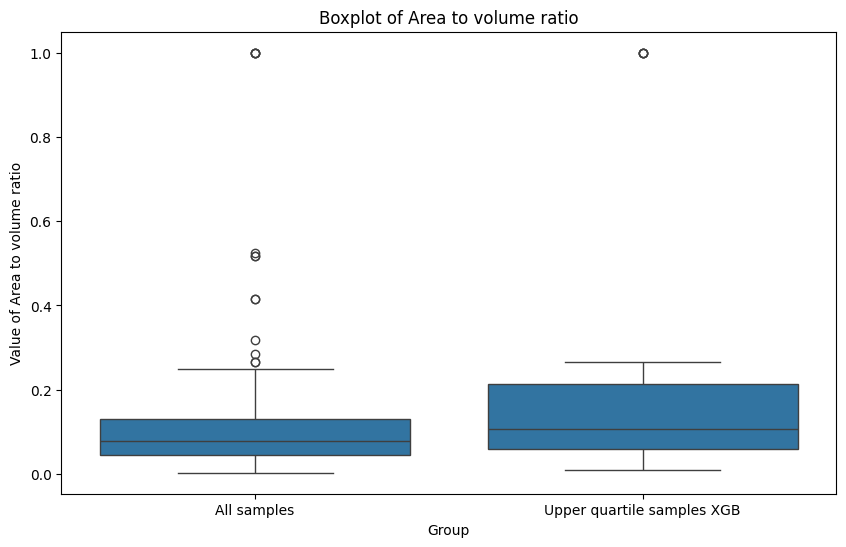

Mann-Whitney U test for Area to volume ratio: statistic=5843.0000, p-value=0.0190


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


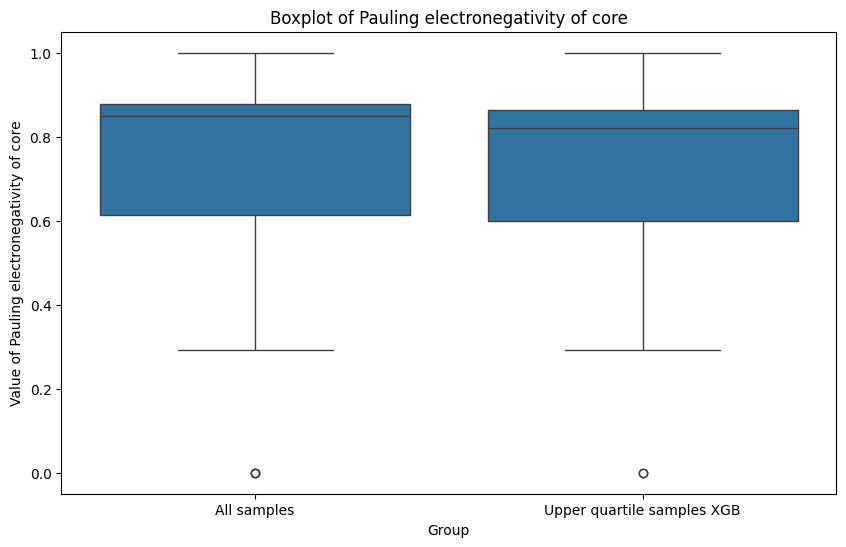

Mann-Whitney U test for Pauling electronegativity of core: statistic=4298.0000, p-value=0.2557


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


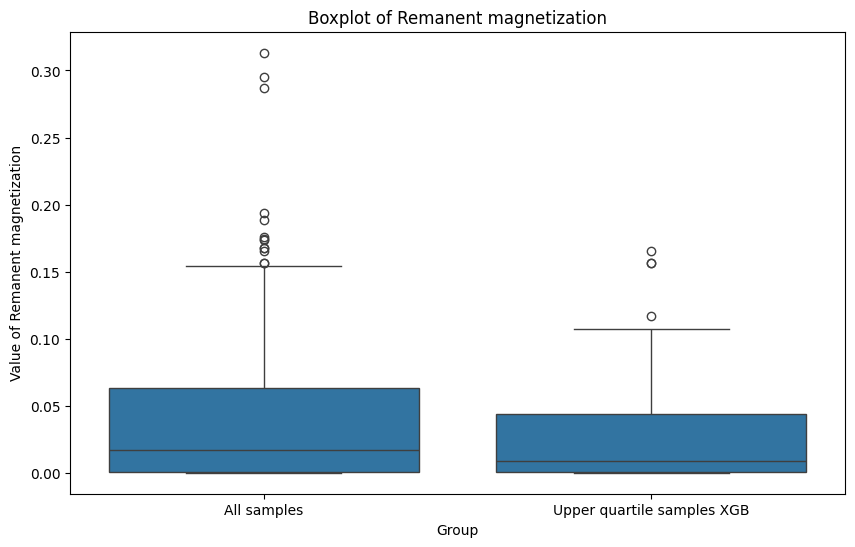

Mann-Whitney U test for Remanent magnetization: statistic=4397.5000, p-value=0.3626


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


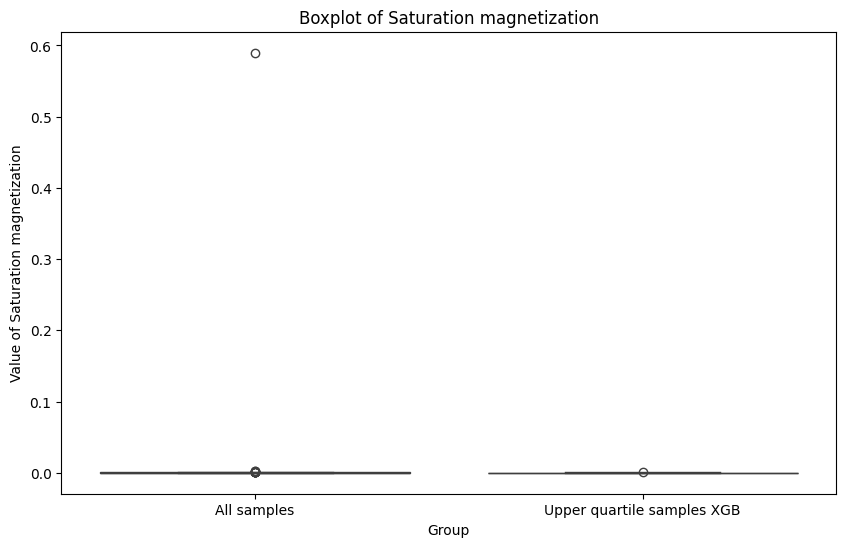

Mann-Whitney U test for Saturation magnetization: statistic=3943.0000, p-value=0.0530


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


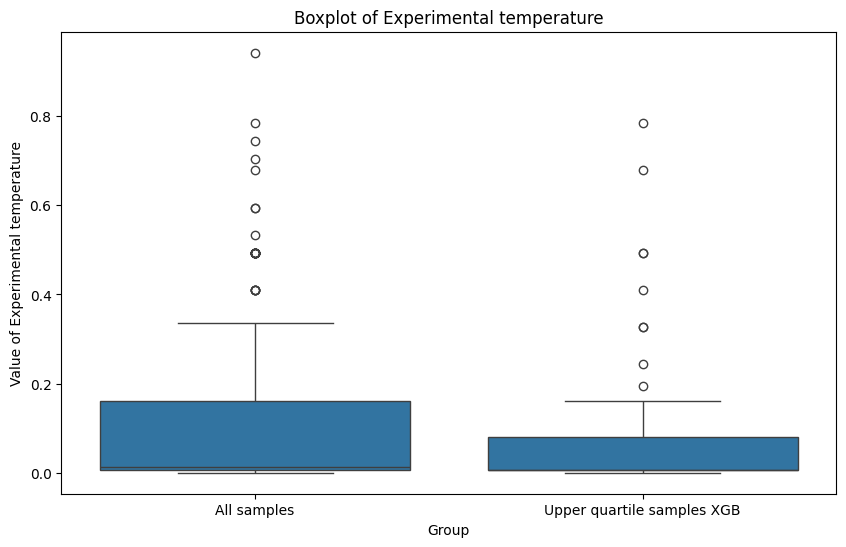

Mann-Whitney U test for Experimental temperature: statistic=3899.0000, p-value=0.0394


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


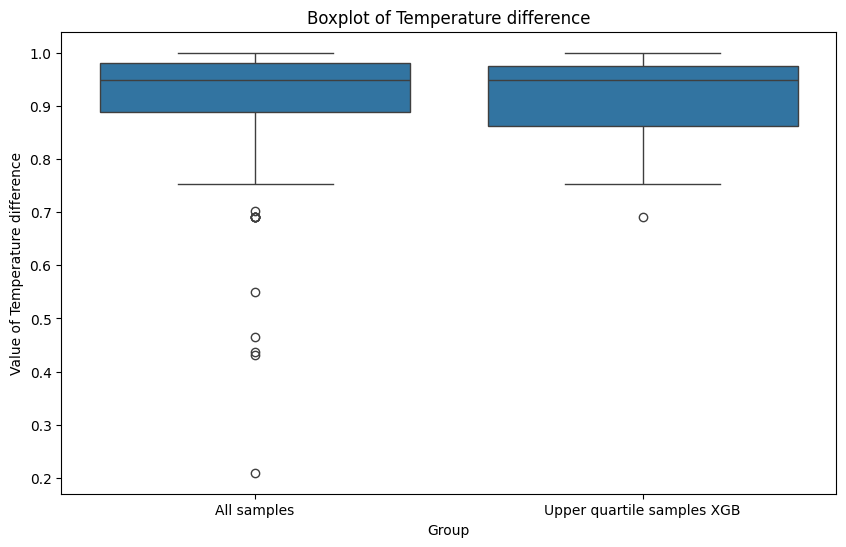

Mann-Whitney U test for Temperature difference: statistic=4476.0000, p-value=0.4632


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


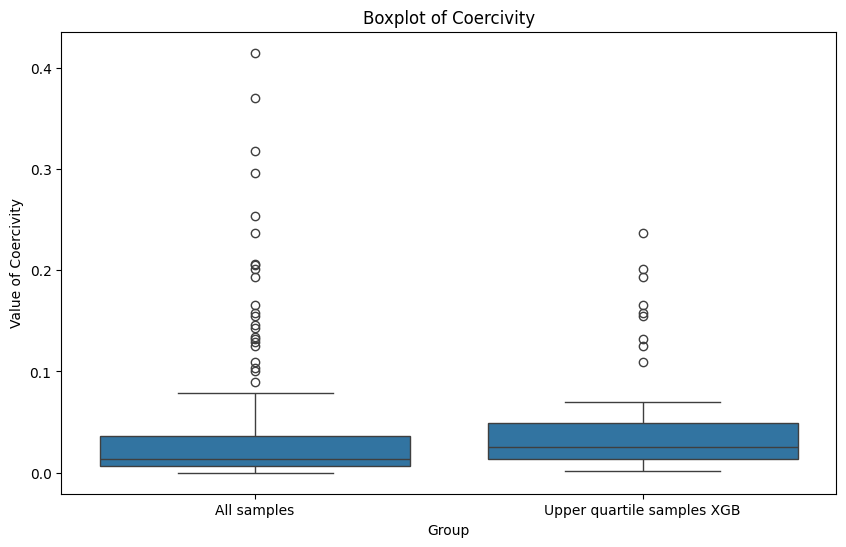

Mann-Whitney U test for Coercivity: statistic=6093.0000, p-value=0.0036


In [ ]:
# Function for building boxplot and Mann-Whitney test
def plot_feature_comparison_boxplot_xgb(feature):
    # Get data for the upper quartile and all others
    upper_quartile_threshold = np.percentile(y_test, 75)
    data_upper = X_test_scaled_df[y_test >= upper_quartile_threshold][feature]
    data_all = X_test_scaled_df[feature]

    # Create a new DataFrame for boxplot
    data_combined = pd.DataFrame({
        'Value': np.concatenate([data_all, data_upper]),
        'Group': ['All samples'] * len(data_all) + ['Upper quartile samples XGB'] * len(data_upper)
    })

    # Visualization of distributions via boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Group', y='Value', data=data_combined)
    plt.title(f'Boxplot of {feature}')
    plt.xlabel('Group')
    plt.ylabel(f'Value of {feature}')
    plt.show()

    # Mann-Witney statistical test
    stat, p_value = stats.mannwhitneyu(data_upper, data_all)
    print(f'Mann-Whitney U test for {feature}: statistic={stat:.4f}, p-value={p_value:.4f}')

# For each important feature from XGB build charts and run statistical test
for feature in important_features:
    plot_feature_comparison_boxplot_xgb(feature)

# KAN

In [ ]:
!pip install git+https://github.com/KindXiaoming/pykan.git > None

  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-ndnxyx36


In [ ]:
import torch
from kan import KAN
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.ndimage import gaussian_filter1d

In [ ]:
# Fixing random seed for reproducibility
def seed_everything(seed=1984):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(1984)

In [ ]:
# Loading data
df = pd.read_csv("/content/final_data_exchange_bias.csv")

# Dropping unnecessary columns
df = df.drop(columns=['core', 'shell', 'formula'])

In [ ]:
# Renaming columns
rename_dict = {
    'area/volume': 'Area to volume ratio',
    'h_range_max_koe': 'Maximum field range',
    'Tc': 'Curie temperature',
    'temperature_k': 'Experimental temperature',
    'sat_em_g': 'Saturation magnetization',
    'coer_oe': 'Coercivity',
    'mr (emu/g)': 'Remanent magnetization',
    'exc_bias_oe': 'Exchange bias shift',
    'exc_dir': 'Exchange shift direction',
    'ver_shift_emu_g': 'Vertical shift',
    'ver_s_dir': 'Vertical shift direction',
    'fc_field_t': 'Magnetic field strength',
    'sphericity': 'Sphericity',
    'max/min': 'Geometric anisotropy',
    'core_b': 'Core b lattice parameter',
    'core_alpha': 'Core alpha angle',
    'core_beta': 'Core beta angle',
    'core_gamma': 'Core gamma angle',
    'shell_b': 'Shell b lattice parameter',
    'shell_alpha': 'Shell alpha angle',
    'shell_beta': 'Shell beta angle',
    'shell_gamma': 'Shell gamma angle',
    'num_of_magn_ions': 'Magnetic ion ratio',
    'Tn-Tb/Tn': 'Temperature difference',
    'Aex': 'Exchange stiffness coefficient',
    'core_c/a': 'Core lattice ratio с to a',
    'core_pauling_electronegativity': 'Pauling electronegativity of core',
    'shell_pauling_electronegativity': 'Pauling electronegativity of shell',
    'core_sum_vec': 'Valence electron concentration of core',
    'core_sum_work_function': 'Work function of core',
    'shell_sum_vec': 'Valence electron concentration of shell',
    'shell_sum_work_function': 'Work function of shell',
    'core_pauling_electronegativity_difference': 'Pauling electronegativity difference of core',
    'core_vec_difference': 'Valence electron concentration difference of core',
    'core_work_function_difference': 'Work function difference of core',
    'shell_pauling_electronegativity_difference': 'Pauling electronegativity difference of shell',
    'shell_vec_difference': 'Valence electron concentration difference of shell',
    'shell_work_function_difference': 'Work function difference of shell'
}

df = df.rename(columns=rename_dict)

In [ ]:
# Target column
target_column_name = "Exchange bias shift"
X = df[list(df.columns.drop([target_column_name]))]
y = df[target_column_name]

# Applying smoothing to the target variable
y_smooth = gaussian_filter1d(y, sigma=2)

# Log-transforming the target variable
y_log = np.log10(y_smooth)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=1984)

# Normalizing descriptors
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Converting data into PyTorch tensors
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train[:, None], dtype=torch.float32)
test_input = torch.tensor(X_test, dtype=torch.float32)
test_label = torch.tensor(y_test[:, None], dtype=torch.float32)

# Splitting the training set into training and validation sets
train_input, val_input, train_label, val_label = train_test_split(train_input, train_label, test_size=0.0639, random_state=1984)

# Printing shapes for verification
print("Train input shape:", train_input.shape)
print("Train label shape:", train_label.shape)
print("Test input shape:", test_input.shape)
print("Test label shape:", test_label.shape)
print("Validation input shape:", val_input.shape)
print("Validation label shape:", val_label.shape)

Train input shape: torch.Size([732, 37])
Train label shape: torch.Size([732, 1])
Test input shape: torch.Size([196, 37])
Test label shape: torch.Size([196, 1])
Validation input shape: torch.Size([51, 37])
Validation label shape: torch.Size([51, 1])


In [ ]:
# Dictionary to store data
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'val_input': val_input,
    'val_label': val_label,
    'test_input': test_input,
    'test_label': test_label
}

In [ ]:
# Creating KAN model with specified parameters
model = KAN(width=[36, 19, 10, 1], grid=22, k=15)

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001188321)

# Loss function: MSE (Mean Squared Error)
loss_fn = torch.nn.MSELoss()

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
# Training the model
def train(model, data, optimizer, loss_fn, steps):
    train_input = data['train_input']
    train_label = data['train_label']
    val_input = data['val_input']
    val_label = data['val_label']
    test_input = data['test_input']
    test_label = data['test_label']

    model.train()  # Set the model to training mode

    for step in range(steps):
        optimizer.zero_grad()  # Clear gradients before each step

        # Forward pass
        predictions = model(train_input)

        # Calculate loss on the training set
        train_loss = loss_fn(predictions, train_label)

        # Backward pass
        train_loss.backward()

        # Optimization step
        optimizer.step()

        # Validate the model on the validation set
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            val_predictions = model(val_input)
            val_loss = loss_fn(val_predictions, val_label)

            # Calculate R² for training, validation, and test sets
            train_r2 = r2_score(train_label.numpy(), predictions.detach().numpy())
            val_r2 = r2_score(val_label.numpy(), val_predictions.numpy())

            test_predictions = model(test_input)
            test_r2 = r2_score(test_label.numpy(), test_predictions.numpy())

            model.train()  # Switch back to training mode

        # Print loss and metrics at each step
        if (step + 1) % 50 == 0:
            print(f"Step {step + 1}/{steps} - Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, "
                  f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}, Test R²: {test_r2:.4f}")

    # Evaluation on the test set after training is complete
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        test_predictions = model(test_input)
        test_loss = loss_fn(test_predictions, test_label)
        print(f"Final Test Loss: {test_loss.item():.4f}")

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to calculate metrics using cross-validation
def cross_val_metrics(model, X, y, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=1984)

    r2_scores = []
    mae_scores = []
    rmse_scores = []

    for train_idx, val_idx in kf.split(X):
        # Splitting data into training and validation sets for each fold
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]

        # Model predictions
        with torch.no_grad():
            model.eval()
            train_preds_fold = model.forward(torch.tensor(X_train_fold, dtype=torch.float32)).detach().numpy()

        # Calculating metrics for the current fold
        r2_scores.append(r2_score(y_train_fold, train_preds_fold))
        mae_scores.append(mean_absolute_error(y_train_fold, train_preds_fold))
        rmse_scores.append(rmse(y_train_fold, train_preds_fold))

    # Return the average metrics across all folds
    return np.mean(r2_scores), np.mean(mae_scores), np.mean(rmse_scores)

    # Printing average metrics across all folds
    print(f"Cross-Validation R2 Score: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Cross-Validation MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"Cross-Validation RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")

# Training the model
train(model, dataset, optimizer, loss_fn, steps=450)

# Running cross-validation on the training set
cv_r2, cv_mae, cv_rmse = cross_val_metrics(model, X_train, y_train)

Step 50/450 - Training Loss: 0.2708, Validation Loss: 0.2779, Train R²: 0.0114, Val R²: -0.0633, Test R²: -0.0074
Step 100/450 - Training Loss: 0.1049, Validation Loss: 0.1787, Train R²: 0.6169, Val R²: 0.3164, Test R²: 0.3899
Step 150/450 - Training Loss: 0.0510, Validation Loss: 0.1312, Train R²: 0.8137, Val R²: 0.4980, Test R²: 0.5326
Step 200/450 - Training Loss: 0.0331, Validation Loss: 0.1296, Train R²: 0.8791, Val R²: 0.5042, Test R²: 0.5842
Step 250/450 - Training Loss: 0.0229, Validation Loss: 0.1364, Train R²: 0.9164, Val R²: 0.4782, Test R²: 0.6106
Step 300/450 - Training Loss: 0.0164, Validation Loss: 0.1523, Train R²: 0.9400, Val R²: 0.4172, Test R²: 0.6159
Step 350/450 - Training Loss: 0.0133, Validation Loss: 0.1622, Train R²: 0.9513, Val R²: 0.3793, Test R²: 0.6189
Step 400/450 - Training Loss: 0.0102, Validation Loss: 0.1680, Train R²: 0.9627, Val R²: 0.3571, Test R²: 0.6563
Step 450/450 - Training Loss: 0.0089, Validation Loss: 0.1688, Train R²: 0.9676, Val R²: 0.3541

## SHAP KAN


In [ ]:
df.columns

Index(['Area to volume ratio', 'Maximum field range', 'Curie temperature',
       'Experimental temperature', 'Saturation magnetization', 'Coercivity',
       'Remanent magnetization', 'Exchange bias shift',
       'Exchange shift direction', 'Vertical shift',
       'Vertical shift direction', 'Magnetic field strength', 'Sphericity',
       'Geometric anisotropy', 'Core b lattice parameter', 'Core alpha angle',
       'Core beta angle', 'Core gamma angle', 'Shell b lattice parameter',
       'Shell alpha angle', 'Shell beta angle', 'Shell gamma angle',
       'Magnetic ion ratio', 'Temperature difference',
       'Exchange stiffness coefficient', 'Core lattice ratio с to a',
       'Pauling electronegativity of core',
       'Pauling electronegativity of shell',
       'Valence electron concentration of core', 'Work function of core',
       'Valence electron concentration of shell', 'Work function of shell',
       'Pauling electronegativity difference of core',
       'Valence elect

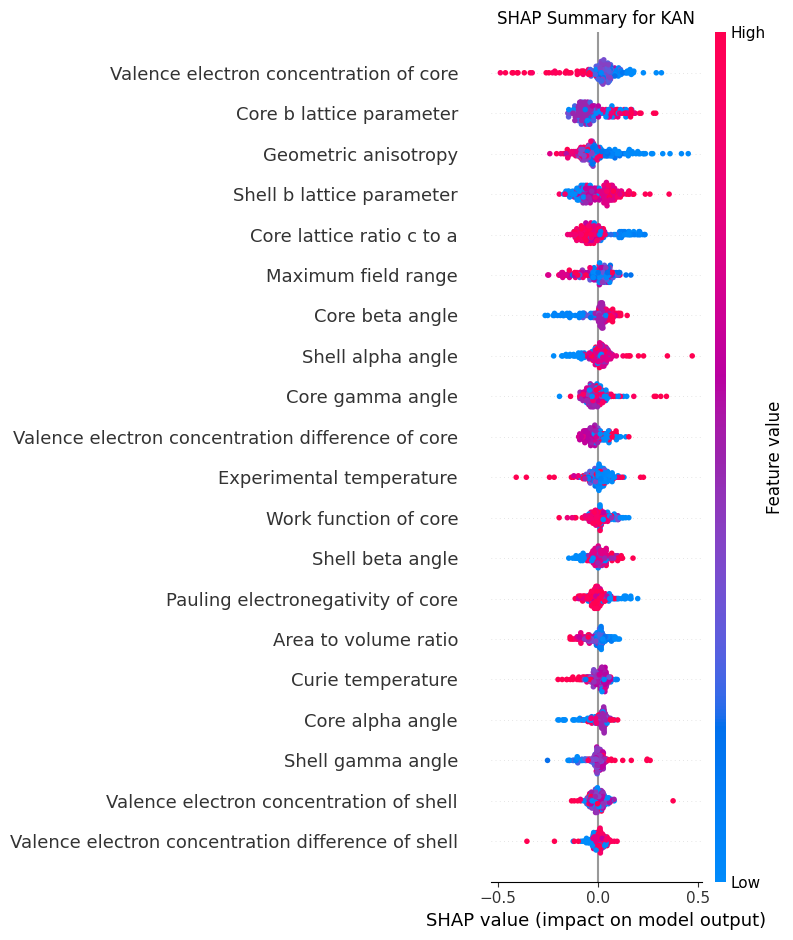

In [ ]:
# Set the model to evaluation mode
model.eval()  # Using the trained model, for example, the variable model

# Convert input data to numpy format
X_train_np = train_input.detach().cpu().numpy()
X_test_np = test_input.detach().cpu().numpy()

# Define the original feature names
feature_names = ['Area to volume ratio', 'Maximum field range', 'Curie temperature',
                'Experimental temperature', 'Saturation magnetization', 'Coercivity',
                'Remanent magnetization', 'Exchange bias shift',
                'Exchange shift direction', 'Vertical shift',
                'Vertical shift direction', 'Magnetic field strength', 'Sphericity',
                'Geometric anisotropy', 'Core b lattice parameter', 'Core alpha angle',
                'Core beta angle', 'Core gamma angle', 'Shell b lattice parameter',
                'Shell alpha angle', 'Shell beta angle', 'Shell gamma angle',
                'Magnetic ion ratio', 'Temperature difference',
                'Exchange stiffness coefficient', 'Core lattice ratio с to a',
                'Pauling electronegativity of core',
                'Pauling electronegativity of shell',
                'Valence electron concentration of core', 'Work function of core',
                'Valence electron concentration of shell', 'Work function of shell',
                'Pauling electronegativity difference of core',
                'Valence electron concentration difference of core',
                'Work function difference of core',
                'Pauling electronegativity difference of shell',
                'Valence electron concentration difference of shell',
                'Work function difference of shell']

# Index of the 'Exchange bias shift' feature to exclude
exclude_feature_idx = feature_names.index('Exchange bias shift')

# Remove 'Exchange bias shift' from both train and test datasets
X_train_np = np.delete(X_train_np, exclude_feature_idx, axis=1)
X_test_np = np.delete(X_test_np, exclude_feature_idx, axis=1)

# Also remove it from the feature names list
feature_names = [name for i, name in enumerate(feature_names) if i != exclude_feature_idx]

# Convert the data back to tensors for SHAP
train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
test_tensor = torch.tensor(X_test_np, dtype=torch.float32)

# Create a SHAP explainer
explainer = shap.GradientExplainer(model, train_tensor)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(test_tensor)

# Convert SHAP values to numpy array
if isinstance(shap_values, list):
    shap_values_np = np.array(shap_values[0])  # Use the first element for regression
else:
    shap_values_np = np.array(shap_values)

# If SHAP values are multidimensional (samples, features, outputs), average across outputs
if shap_values_np.ndim == 3:
    shap_values_np = shap_values_np.mean(axis=2)

# Create figure and axis before plotting SHAP
plt.figure(figsize=(10, 6))

# Plot SHAP summary plot with updated feature names
shap.summary_plot(shap_values_np, X_test_np, feature_names=feature_names, show=False)

# Add title via matplotlib
plt.title("SHAP Summary for KAN")
plt.tight_layout()  # To prevent plot cutting
plt.show()

## Compare 25% predicted values of KAN

In [ ]:
df.columns

Index(['Area to volume ratio', 'Maximum field range', 'Curie temperature',
       'Experimental temperature', 'Saturation magnetization', 'Coercivity',
       'Remanent magnetization', 'Exchange bias shift',
       'Exchange shift direction', 'Vertical shift',
       'Vertical shift direction', 'Magnetic field strength', 'Sphericity',
       'Geometric anisotropy', 'Core b lattice parameter', 'Core alpha angle',
       'Core beta angle', 'Core gamma angle', 'Shell b lattice parameter',
       'Shell alpha angle', 'Shell beta angle', 'Shell gamma angle',
       'Magnetic ion ratio', 'Temperature difference',
       'Exchange stiffness coefficient', 'Core lattice ratio с to a',
       'Pauling electronegativity of core',
       'Pauling electronegativity of shell',
       'Valence electron concentration of core', 'Work function of core',
       'Valence electron concentration of shell', 'Work function of shell',
       'Pauling electronegativity difference of core',
       'Valence elect

<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


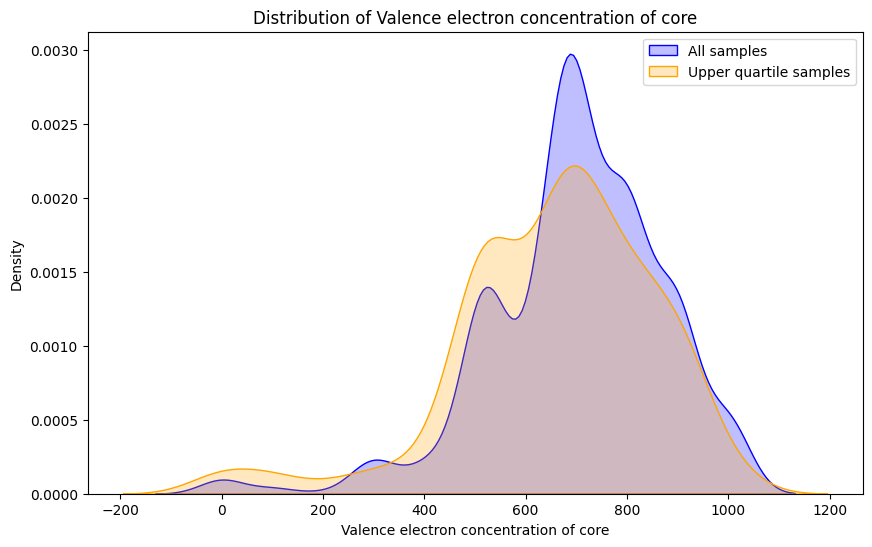

Mann-Whitney U test for Valence electron concentration of core: statistic=105683.5000, p-value=0.0039


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


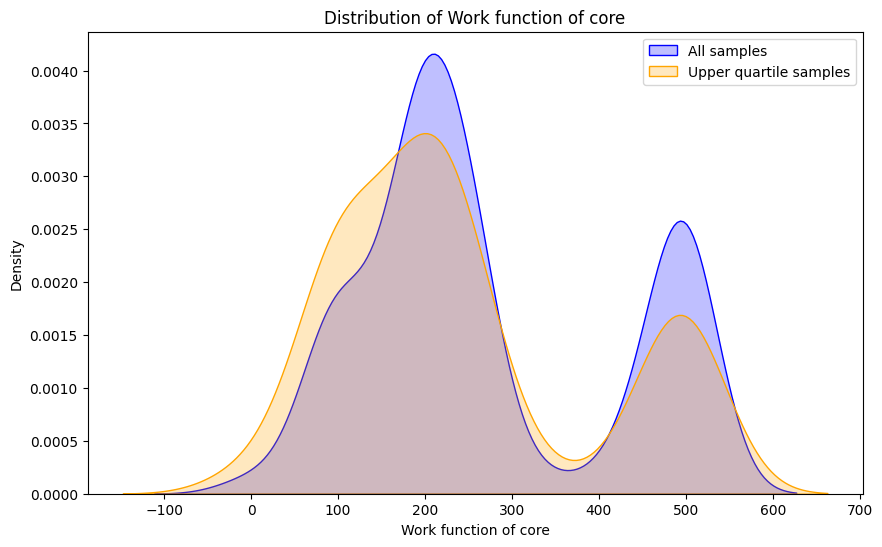

Mann-Whitney U test for Work function of core: statistic=105556.0000, p-value=0.0036


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


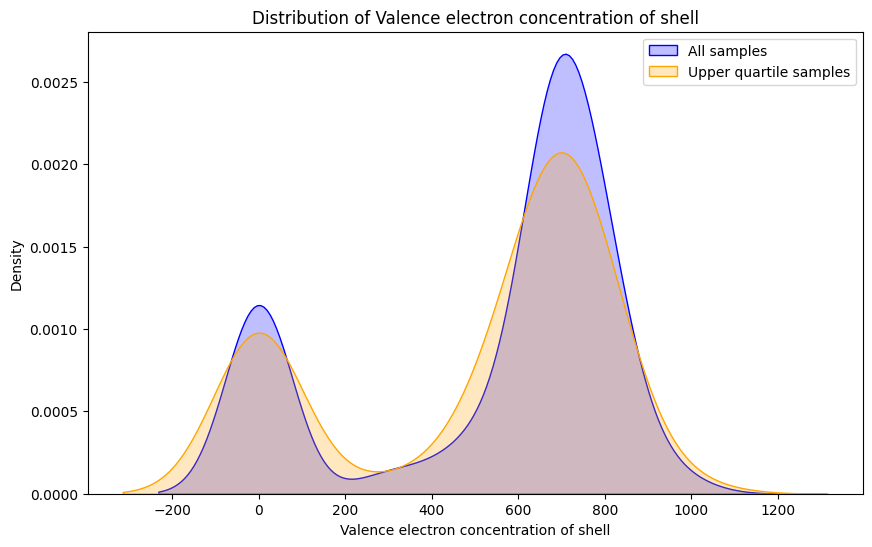

Mann-Whitney U test for Valence electron concentration of shell: statistic=110042.5000, p-value=0.0440


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


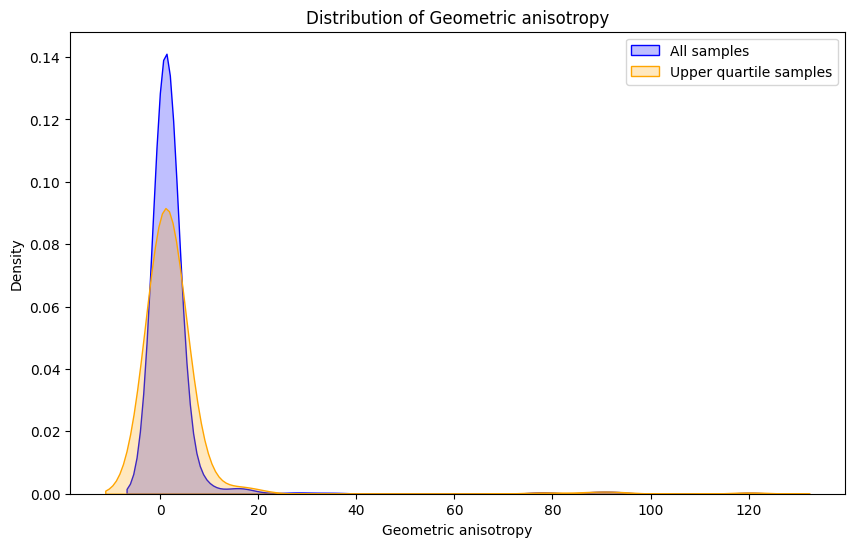

Mann-Whitney U test for Geometric anisotropy: statistic=119834.5000, p-value=0.9728


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


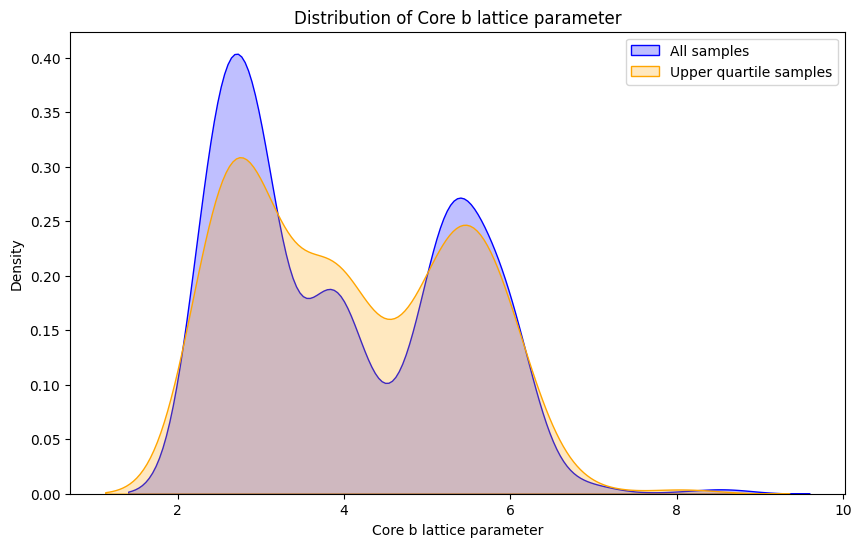

Mann-Whitney U test for Core b lattice parameter: statistic=126377.0000, p-value=0.1918


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


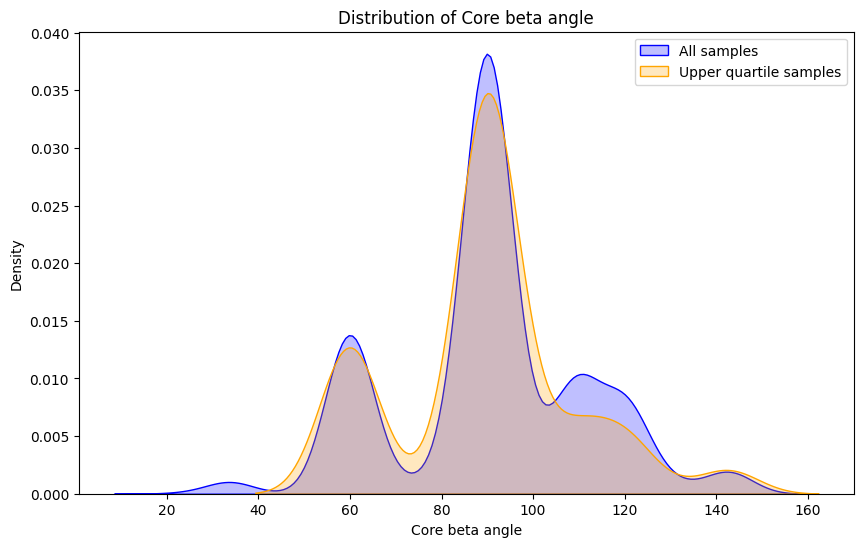

Mann-Whitney U test for Core beta angle: statistic=115119.0000, p-value=0.3116


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


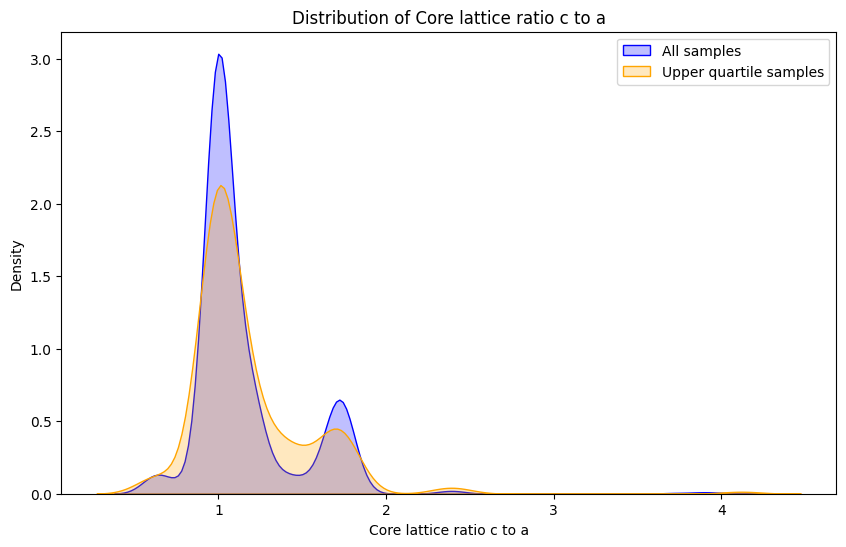

Mann-Whitney U test for Core lattice ratio с to a: statistic=125358.5000, p-value=0.2455


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


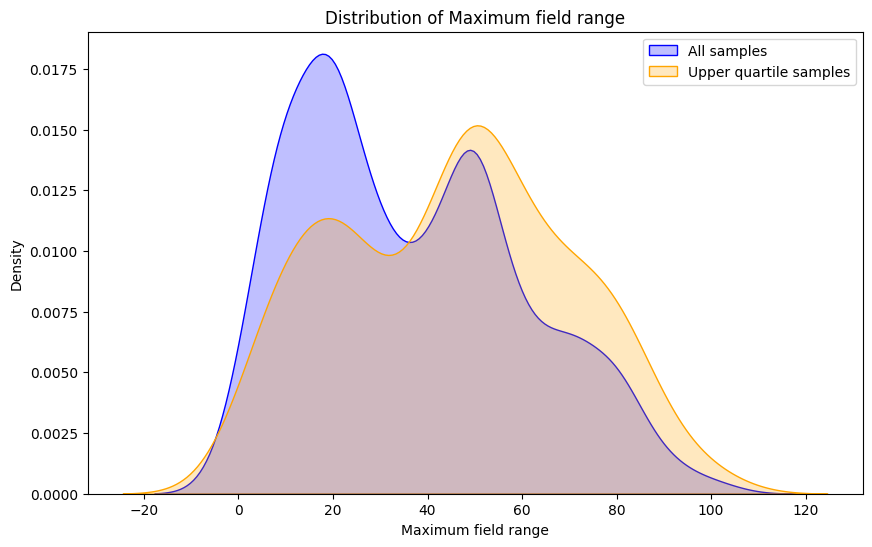

Mann-Whitney U test for Maximum field range: statistic=144088.5000, p-value=0.0000


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


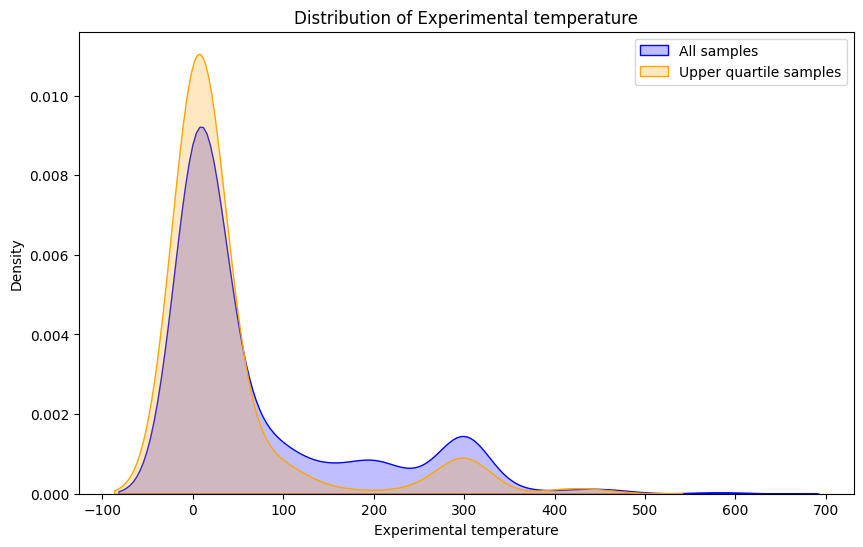

Mann-Whitney U test for Experimental temperature: statistic=92987.5000, p-value=0.0000


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


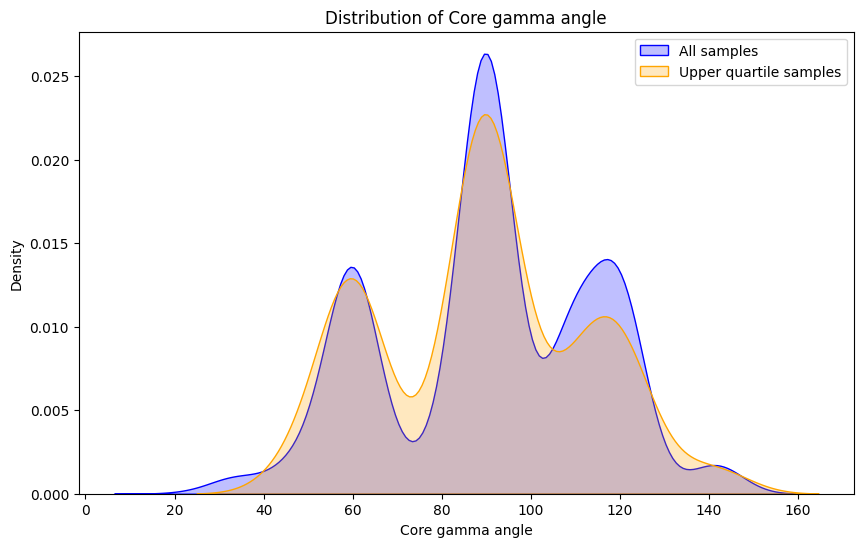

Mann-Whitney U test for Core gamma angle: statistic=113533.5000, p-value=0.1895


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


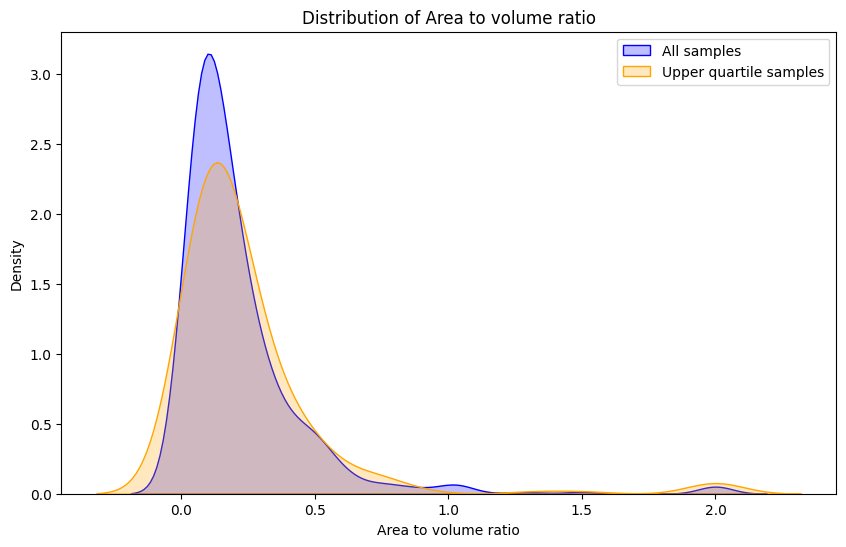

Mann-Whitney U test for Area to volume ratio: statistic=126916.0000, p-value=0.1578


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


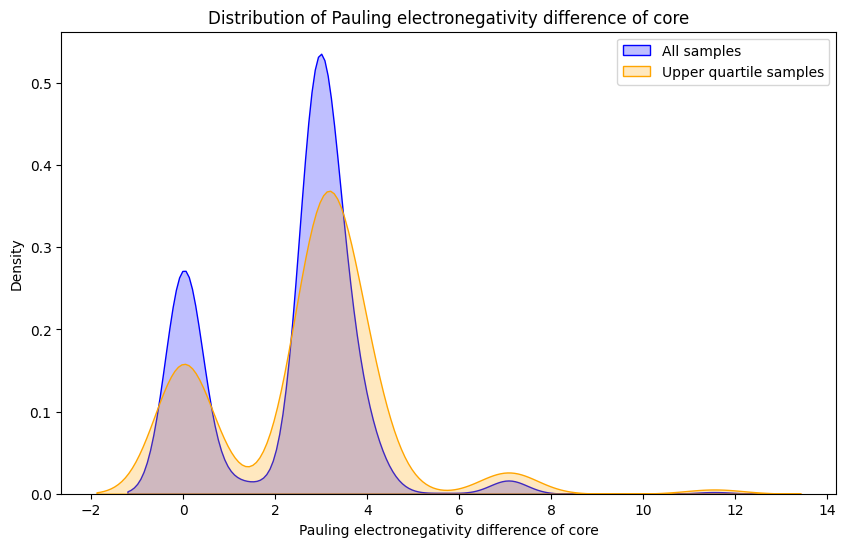

Mann-Whitney U test for Pauling electronegativity difference of core: statistic=139015.0000, p-value=0.0001


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


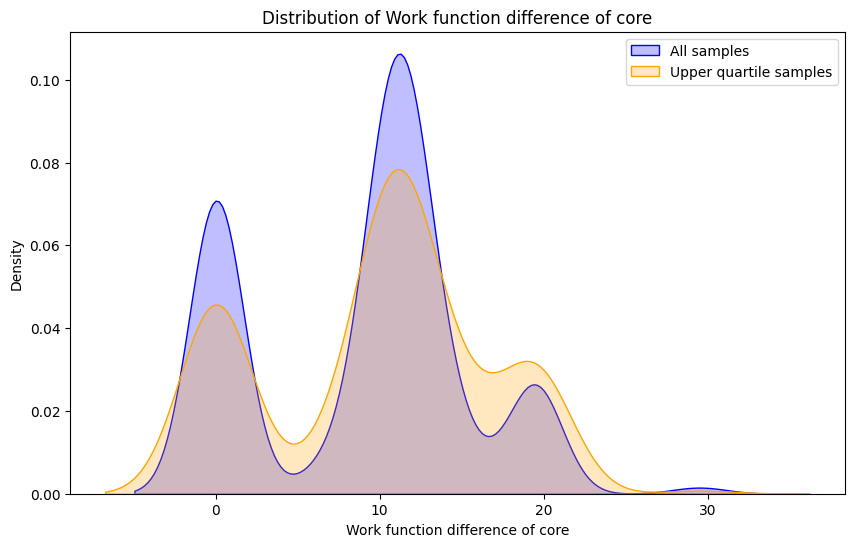

Mann-Whitney U test for Work function difference of core: statistic=127517.5000, p-value=0.1208


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


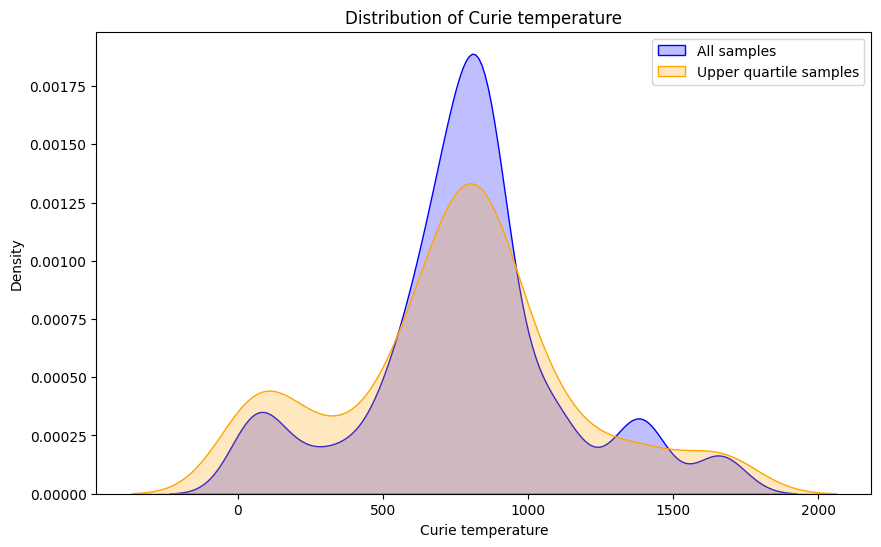

Mann-Whitney U test for Curie temperature: statistic=115823.0000, p-value=0.4066


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


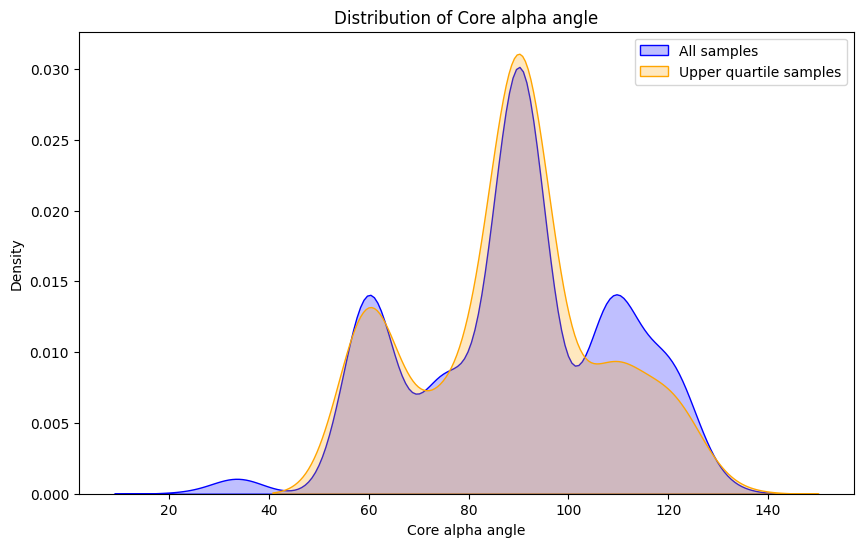

Mann-Whitney U test for Core alpha angle: statistic=114051.5000, p-value=0.2257


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


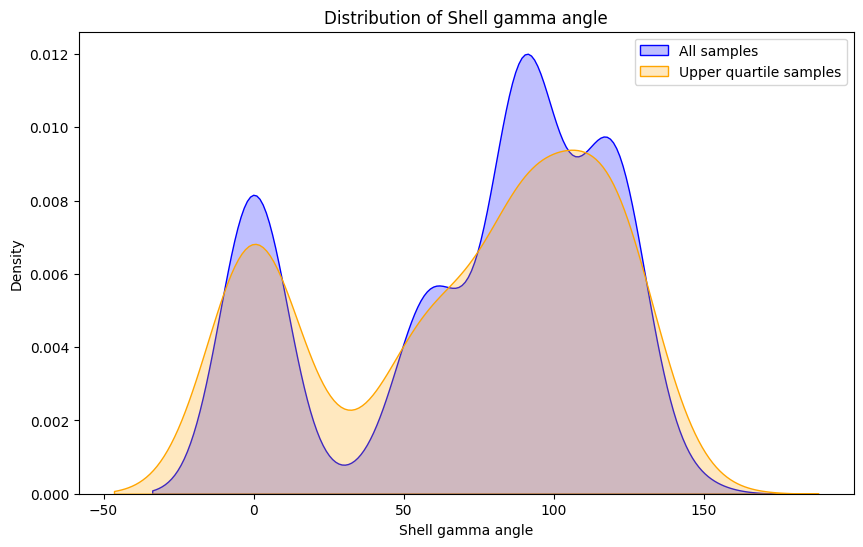

Mann-Whitney U test for Shell gamma angle: statistic=116612.5000, p-value=0.4962


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


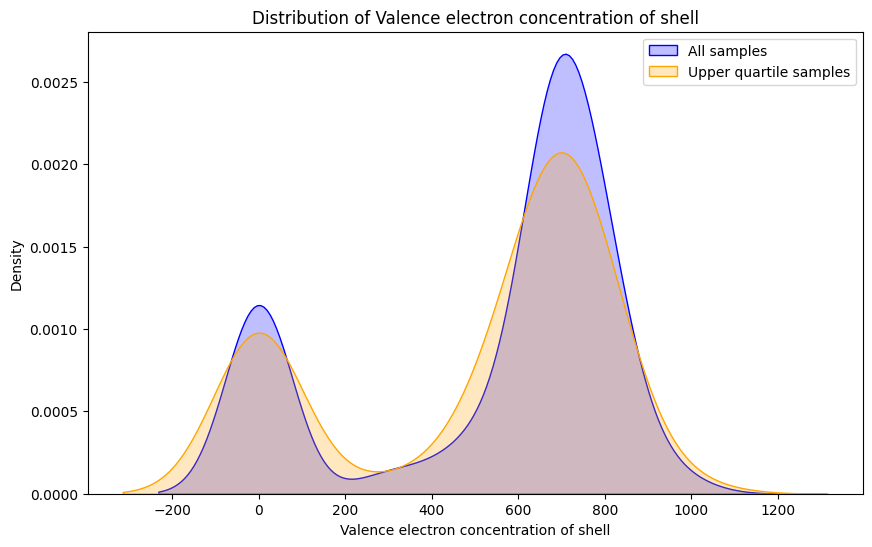

Mann-Whitney U test for Valence electron concentration of shell: statistic=110042.5000, p-value=0.0440


<ipython-input-26-7cb1e15b147b>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
<ipython-input-26-7cb1e15b147b>:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')


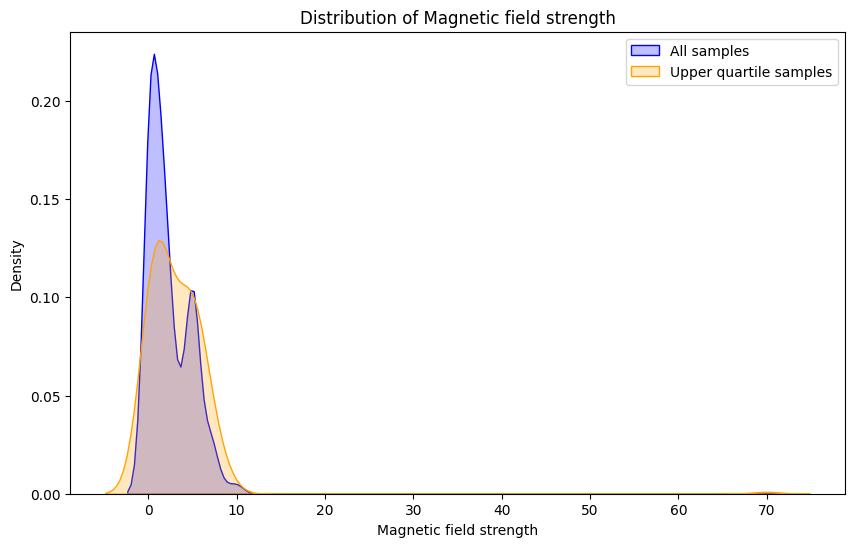

Mann-Whitney U test for Magnetic field strength: statistic=139071.0000, p-value=0.0001


In [ ]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Select the samples with the greatest displacements (upper quartile)
upper_quartile_threshold = np.percentile(y, 75)
large_eb_shift_samples = df[df['Exchange bias shift'] >= upper_quartile_threshold]

# Source and top quartile by target variable
y_upper_quartile = y[y >= upper_quartile_threshold]
X_upper_quartile = X[df['Exchange bias shift'] >= upper_quartile_threshold]

kan_important_features = [ 'Valence electron concentration of core', 'Work function of core',
  'Valence electron concentration of shell','Geometric anisotropy',
  'Core b lattice parameter', 'Core beta angle','Core lattice ratio с to a',
  'Maximum field range', 'Experimental temperature', 'Core gamma angle',
  'Area to volume ratio', 'Pauling electronegativity difference of core',
  'Work function difference of core', 'Curie temperature', 'Core alpha angle',
  'Shell gamma angle', 'Valence electron concentration of shell', 'Magnetic field strength',
  ]

# Function for constructing Mann-Whitney distributions and tests
def plot_feature_comparison(feature):
    # Get data for the upper quartile and all others
    data_upper = X_upper_quartile[feature]
    data_all = df[feature]

    # Distribution visualization
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data_all, label='All samples', shade=True, color='blue')
    sns.kdeplot(data_upper, label='Upper quartile samples', shade=True, color='orange')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Mann-Witney statistical test
    stat, p_value = stats.mannwhitneyu(data_upper, data_all)
    print(f'Mann-Whitney U test for {feature}: statistic={stat:.4f}, p-value={p_value:.4f}')

# For each important topic for KAN we build charts and run a statistical test
for feature in kan_important_features:
    plot_feature_comparison(feature)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


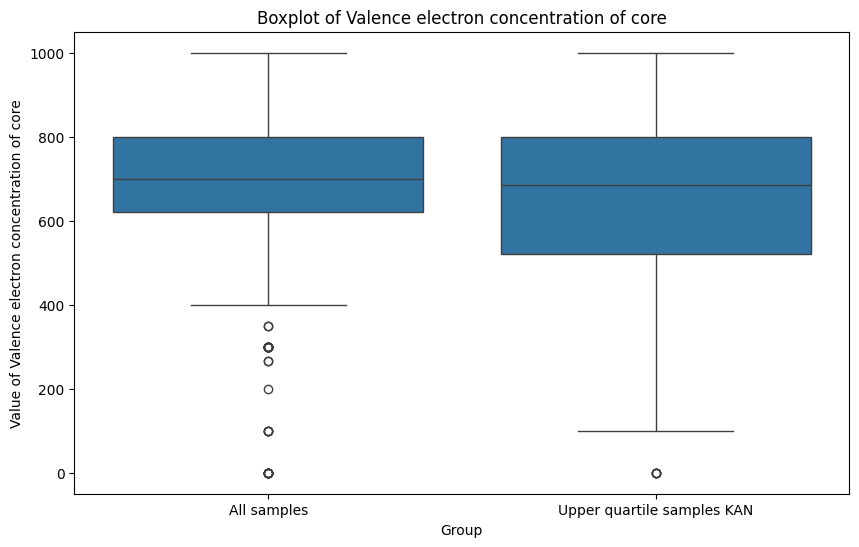

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


Mann-Whitney U test for Valence electron concentration of core: statistic=105683.5000, p-value=0.0039


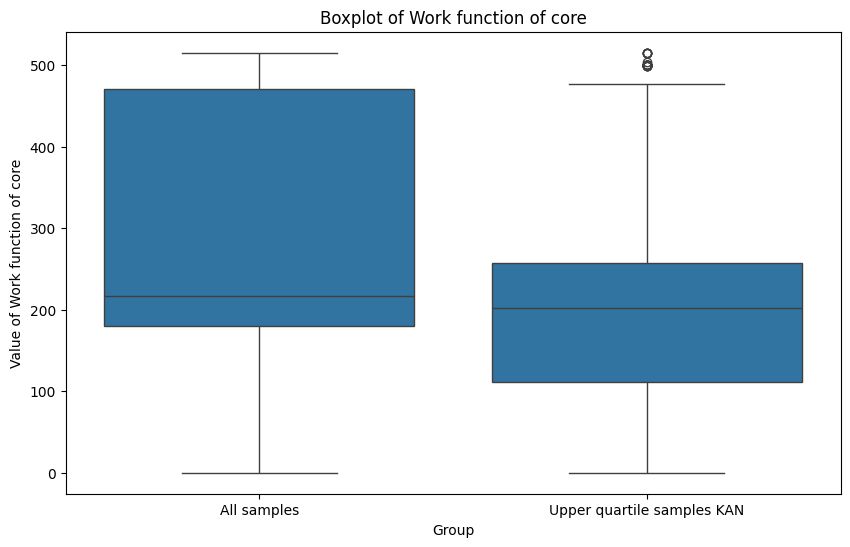

Mann-Whitney U test for Work function of core: statistic=105556.0000, p-value=0.0036


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


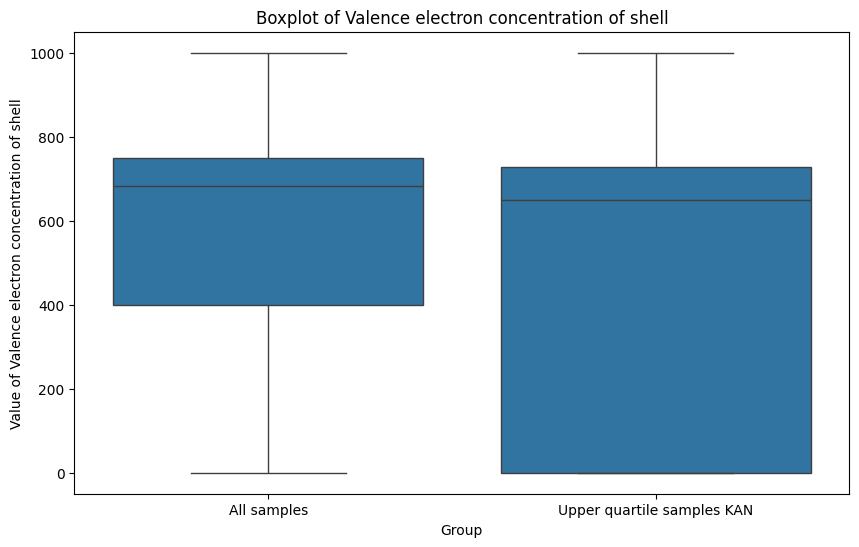

Mann-Whitney U test for Valence electron concentration of shell: statistic=110042.5000, p-value=0.0440


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


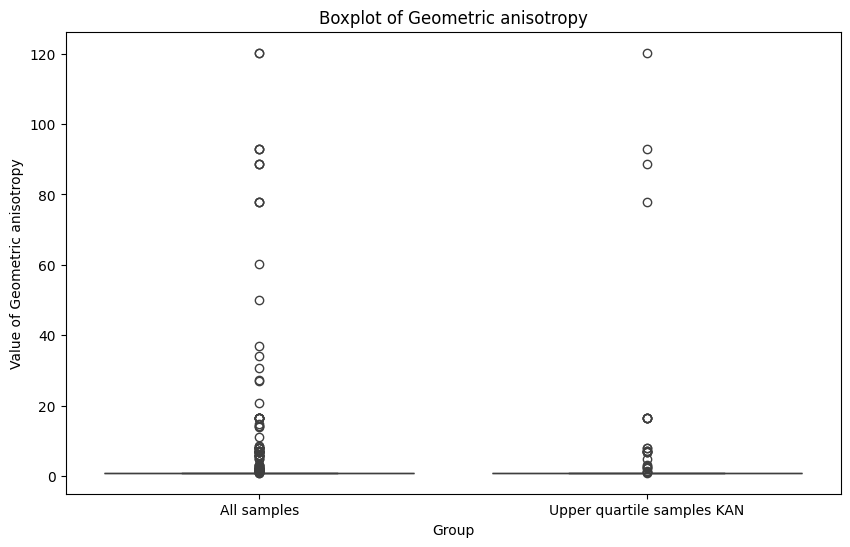

Mann-Whitney U test for Geometric anisotropy: statistic=119834.5000, p-value=0.9728


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


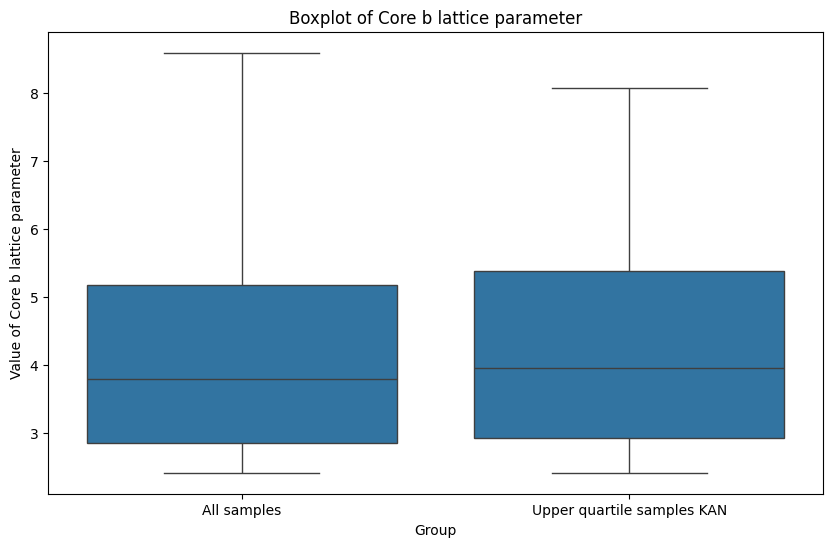

Mann-Whitney U test for Core b lattice parameter: statistic=126377.0000, p-value=0.1918


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


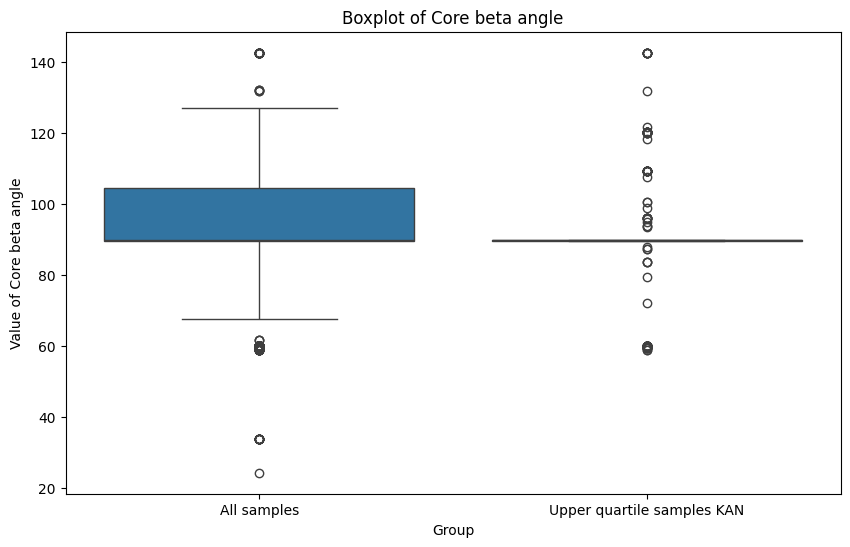

Mann-Whitney U test for Core beta angle: statistic=115119.0000, p-value=0.3116


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


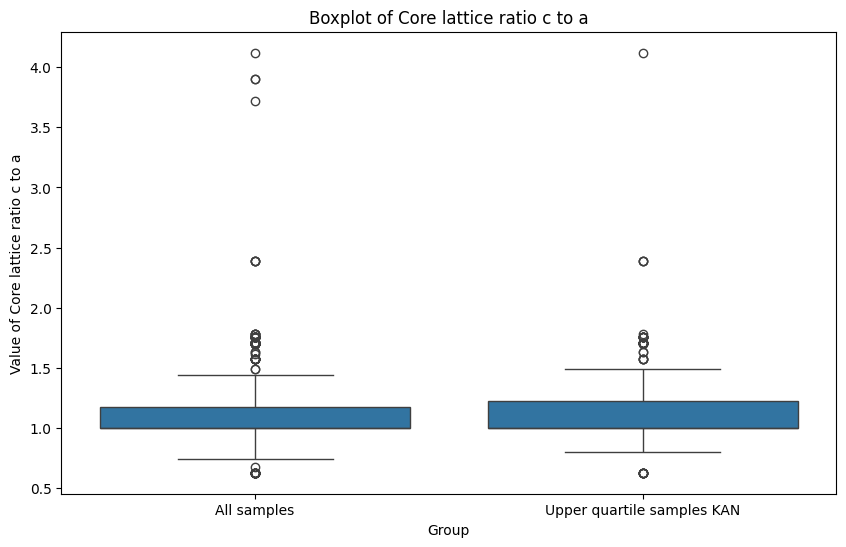

Mann-Whitney U test for Core lattice ratio с to a: statistic=125358.5000, p-value=0.2455


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


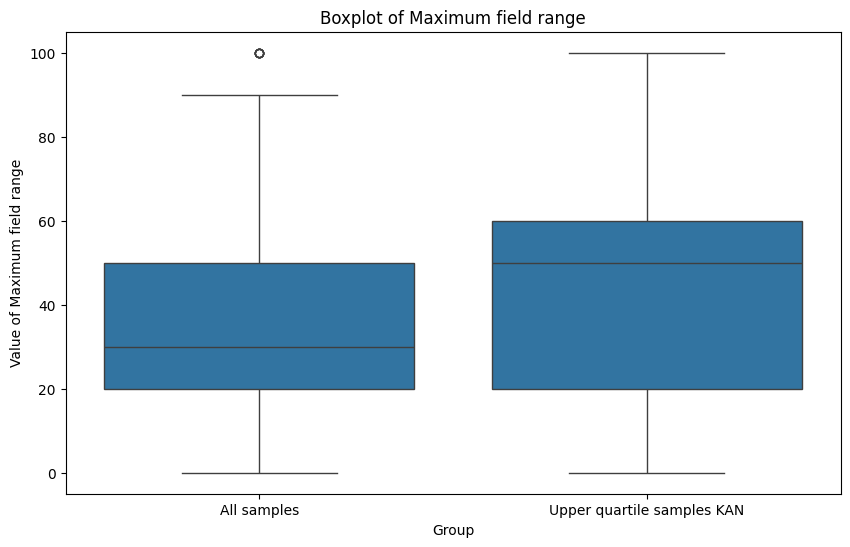

Mann-Whitney U test for Maximum field range: statistic=144088.5000, p-value=0.0000


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


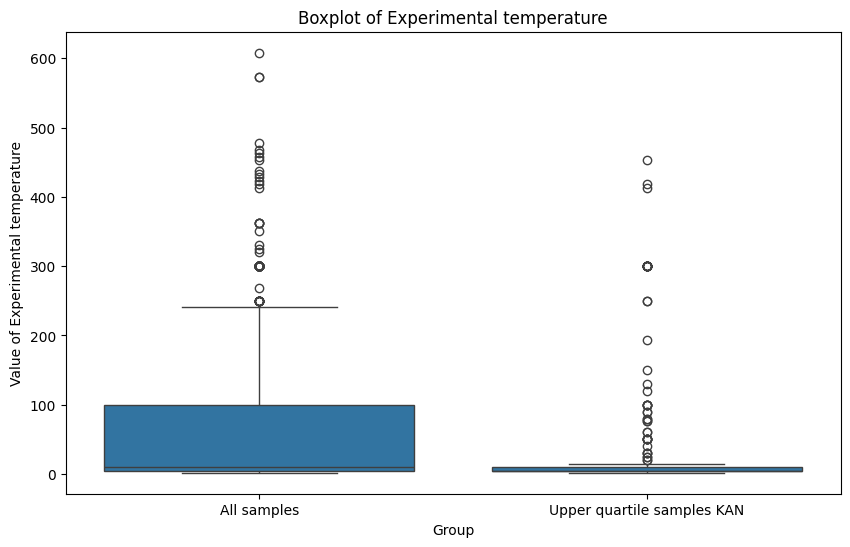

Mann-Whitney U test for Experimental temperature: statistic=92987.5000, p-value=0.0000


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


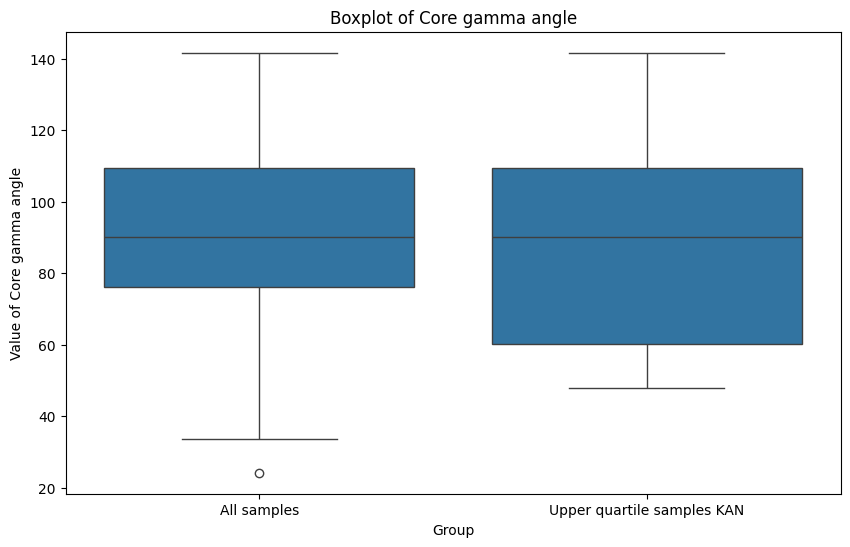

Mann-Whitney U test for Core gamma angle: statistic=113533.5000, p-value=0.1895


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


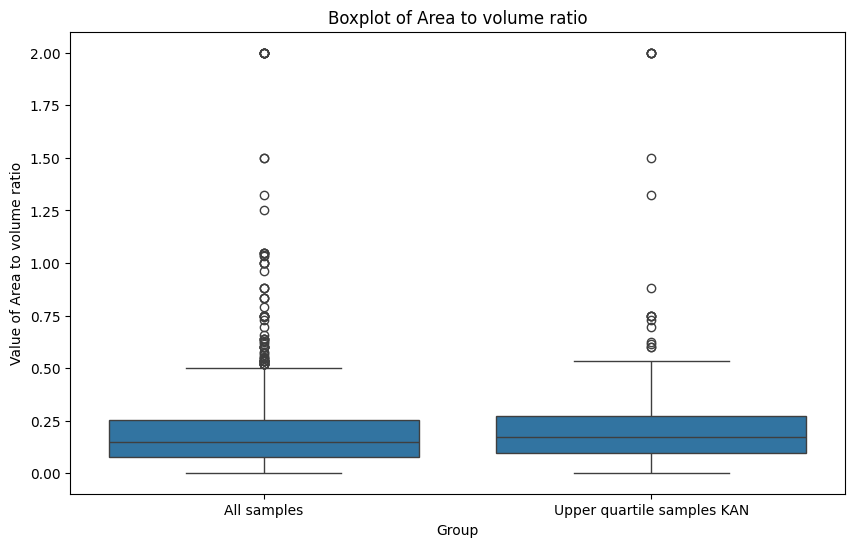

Mann-Whitney U test for Area to volume ratio: statistic=126916.0000, p-value=0.1578


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


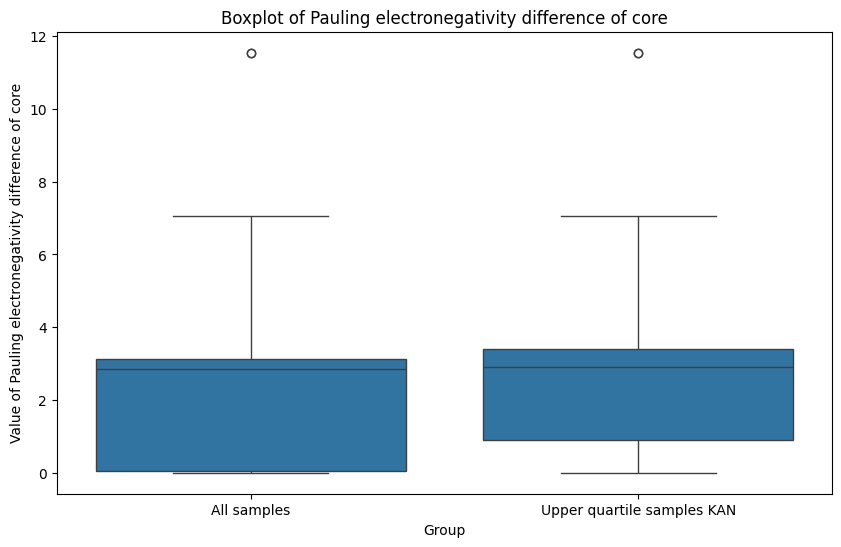

Mann-Whitney U test for Pauling electronegativity difference of core: statistic=139015.0000, p-value=0.0001


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


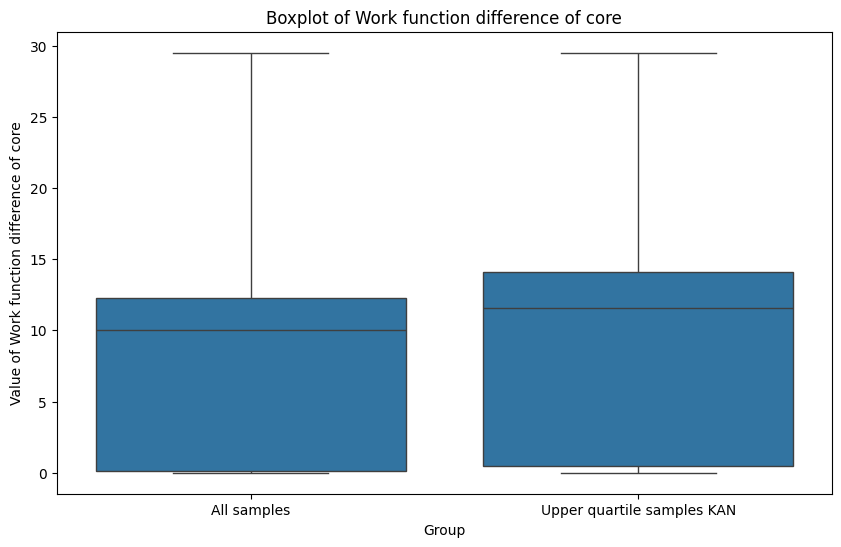

Mann-Whitney U test for Work function difference of core: statistic=127517.5000, p-value=0.1208


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


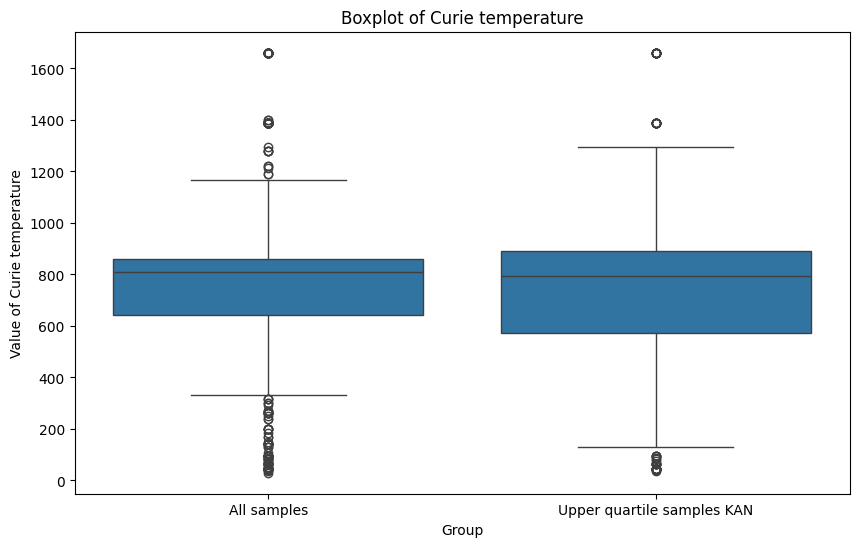

Mann-Whitney U test for Curie temperature: statistic=115823.0000, p-value=0.4066


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


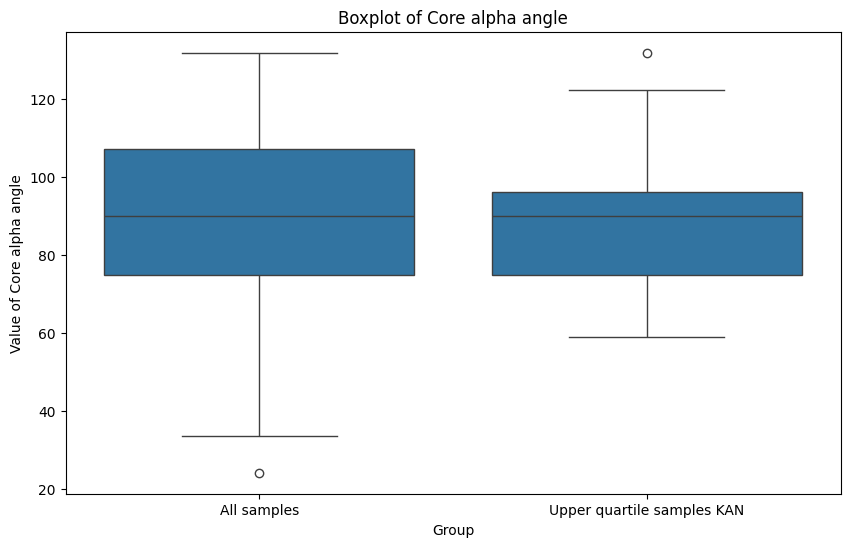

Mann-Whitney U test for Core alpha angle: statistic=114051.5000, p-value=0.2257


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


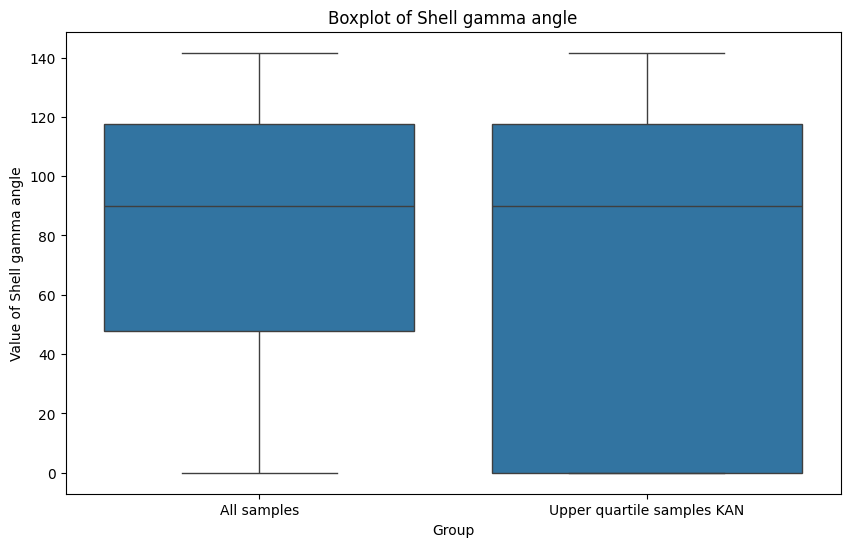

Mann-Whitney U test for Shell gamma angle: statistic=116612.5000, p-value=0.4962


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


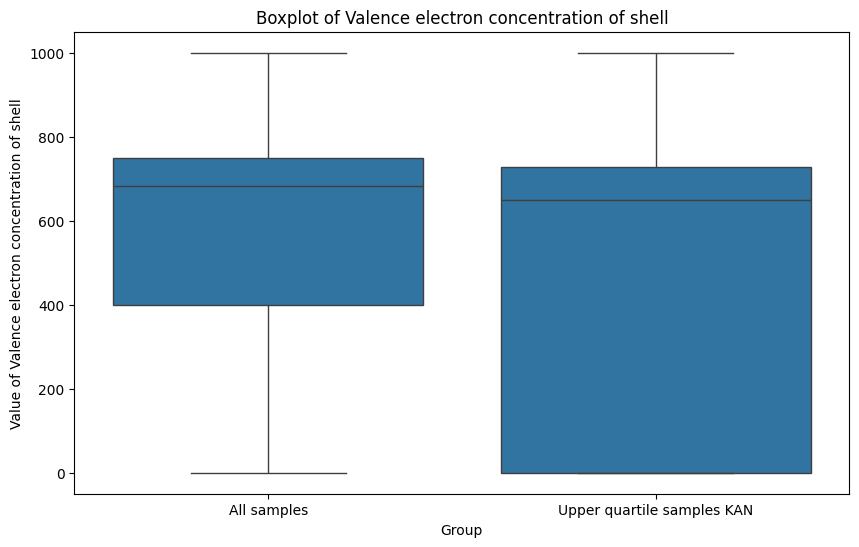

Mann-Whitney U test for Valence electron concentration of shell: statistic=110042.5000, p-value=0.0440


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


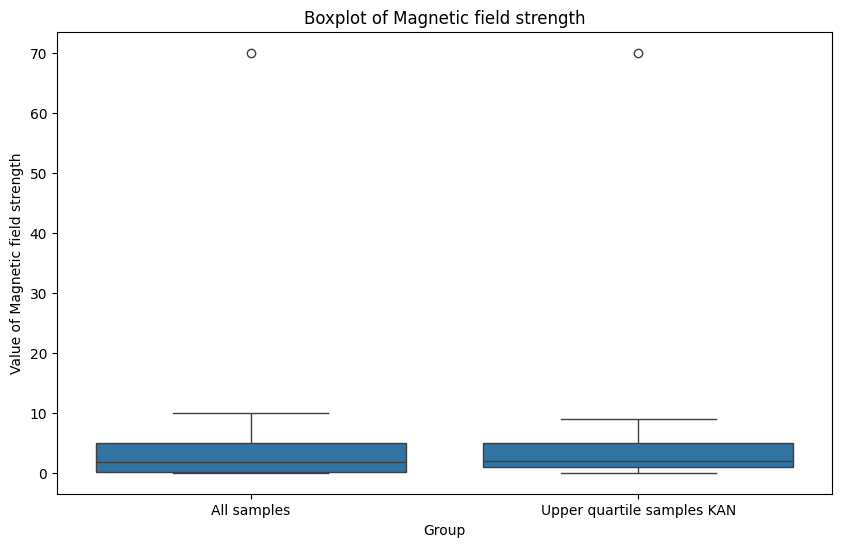

Mann-Whitney U test for Magnetic field strength: statistic=139071.0000, p-value=0.0001


In [ ]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Select the samples with the greatest displacements (upper quartile)
upper_quartile_threshold = np.percentile(y, 75)
large_eb_shift_samples = df[df['Exchange bias shift'] >= upper_quartile_threshold]

# Source and top quartile by target variable
y_upper_quartile = y[y >= upper_quartile_threshold]
X_upper_quartile = X[df['Exchange bias shift'] >= upper_quartile_threshold]

# The most important KAN attributes (by SHAP values)
# Selection of the first N most significant features for KAN
kan_important_features = [
    'Valence electron concentration of core', 'Work function of core',
    'Valence electron concentration of shell', 'Geometric anisotropy',
    'Core b lattice parameter', 'Core beta angle', 'Core lattice ratio с to a',
    'Maximum field range', 'Experimental temperature', 'Core gamma angle',
    'Area to volume ratio', 'Pauling electronegativity difference of core',
    'Work function difference of core', 'Curie temperature', 'Core alpha angle',
    'Shell gamma angle', 'Valence electron concentration of shell', 'Magnetic field strength'
]

# Function for building boxplot and Mann-Whitney test
def plot_feature_comparison_boxplot(feature):
    # Get data for the upper quartile and all others
    data_upper = X_upper_quartile[feature]
    data_all = df[feature]

    # Create a new DataFrame for boxplot
    data_combined = pd.DataFrame({
        'Value': np.concatenate([data_all, data_upper]),
        'Group': ['All samples'] * len(data_all) + ['Upper quartile samples KAN'] * len(data_upper)
    })

    # Visualization of distributions via boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Group', y='Value', data=data_combined)
    plt.title(f'Boxplot of {feature}')
    plt.xlabel('Group')
    plt.ylabel(f'Value of {feature}')
    plt.show()

    # Mann-Witney statistical test
    stat, p_value = stats.mannwhitneyu(data_upper, data_all)
    print(f'Mann-Whitney U test for {feature}: statistic={stat:.4f}, p-value={p_value:.4f}')

# For each important topic for KAN we build charts and run a statistical test
for feature in kan_important_features:
    plot_feature_comparison_boxplot(feature)

# Compare XGB and KAN SHAP distribution and Mann-Whitney U Test

## boxplot

In [ ]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# List of intersecting important features for XGB and KAN
common_features = [
    'Experimental temperature', 'Pauling electronegativity of core', 'Area to volume ratio',
    'Curie temperature', 'Valence electron concentration difference of shell',
    'Magnetic field strength', 'Maximum field range', 'Core alpha angle',
    'Core beta angle', 'Core b lattice parameter', 'Shell b lattice parameter'
]

# Initialize list to store test results
results = []

# Function for building boxplot and saving data distributions for XGB
def plot_feature_comparison_boxplot_xgb(feature):
    # Get data for the upper quartile and all others (XGB)
    upper_quartile_threshold = np.percentile(y_test, 75)
    data_upper_xgb = X_test_scaled_df[y_test >= upper_quartile_threshold][feature]
    data_all_xgb = X_test_scaled_df[feature]

    # Create DataFrame for XGB
    data_combined_xgb = pd.DataFrame({
        'Value': np.concatenate([data_all_xgb, data_upper_xgb]),
        'Group': ['All samples'] * len(data_all_xgb) + ['Upper quartile samples XGB'] * len(data_upper_xgb)
    })

    # Visualization of distributions via boxplot
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='Group', y='Value', data=data_combined_xgb, palette='coolwarm', saturation=0.8)
    plt.title(f'Boxplot of {feature} (XGB)', fontsize=16)
    plt.xlabel('Group', fontsize=14)
    plt.ylabel(f'Values of {feature}', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    # Save XGB data for later use with KAN
    return data_combined_xgb

# Keep the distribution for all intersecting XGB features
xgb_distributions = {}
for feature in common_features:
    print(f'Building boxplot for {feature} (XGB)')
    xgb_distributions[feature] = plot_feature_comparison_boxplot_xgb(feature)

Building combined boxplot for Experimental temperature (XGB vs KAN)


<ipython-input-37-fb8b2a776c28>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_data, palette='Set2', saturation=0.8)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

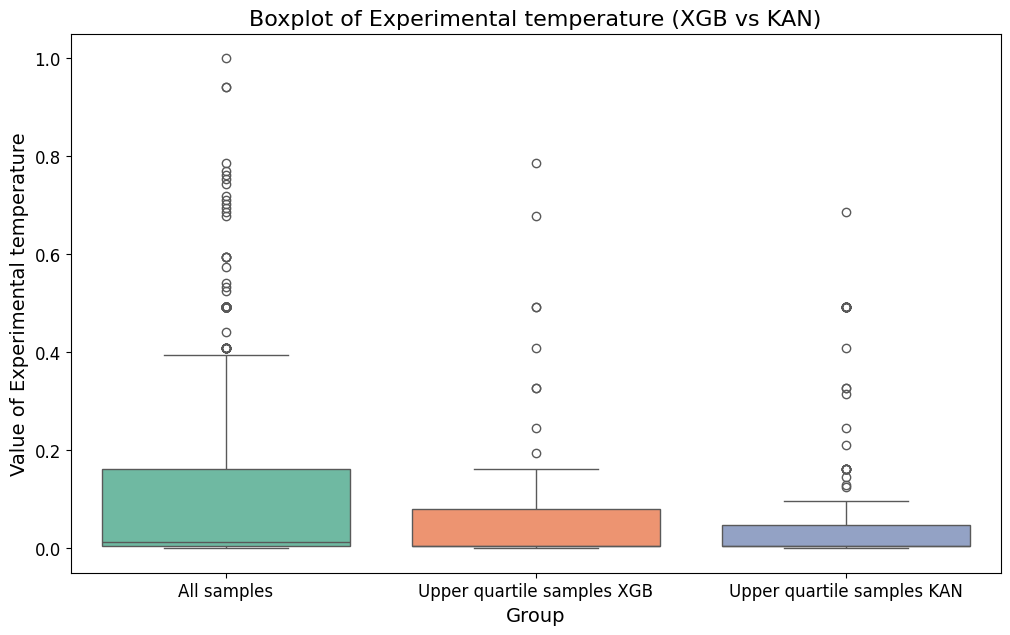

Mann-Whitney U test for Experimental temperature (XGB): statistic=3899.0000, p-value=0.0394
Mann-Whitney U test for Experimental temperature (KAN): statistic=64254.5000, p-value=0.0003
Building combined boxplot for Pauling electronegativity of core (XGB vs KAN)


<ipython-input-37-fb8b2a776c28>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_data, palette='Set2', saturation=0.8)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

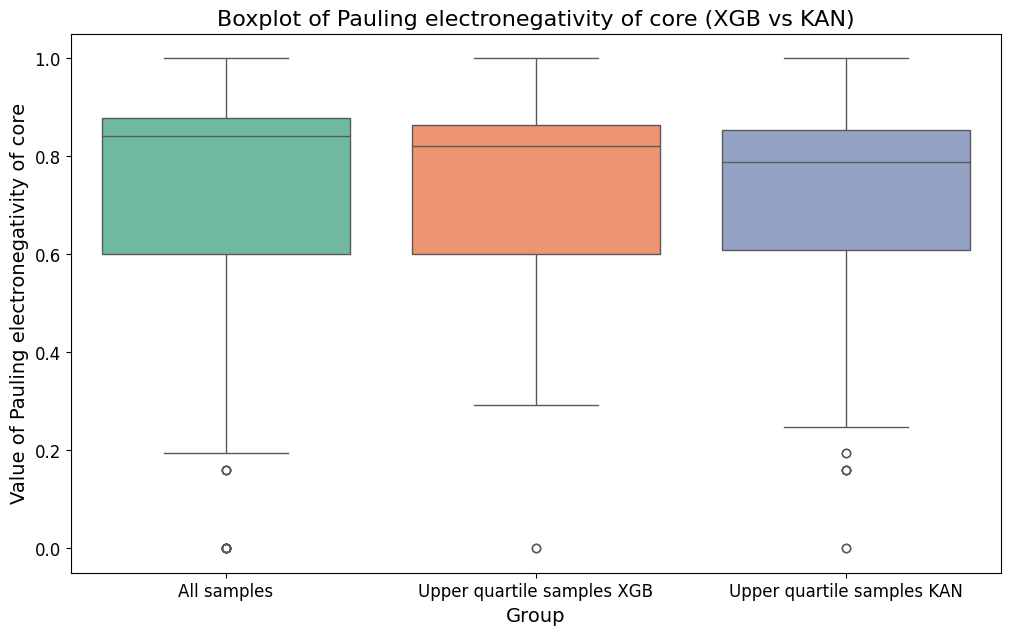

Mann-Whitney U test for Pauling electronegativity of core (XGB): statistic=4298.0000, p-value=0.2557
Mann-Whitney U test for Pauling electronegativity of core (KAN): statistic=71554.5000, p-value=0.1427
Building combined boxplot for Area to volume ratio (XGB vs KAN)


<ipython-input-37-fb8b2a776c28>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_data, palette='Set2', saturation=0.8)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

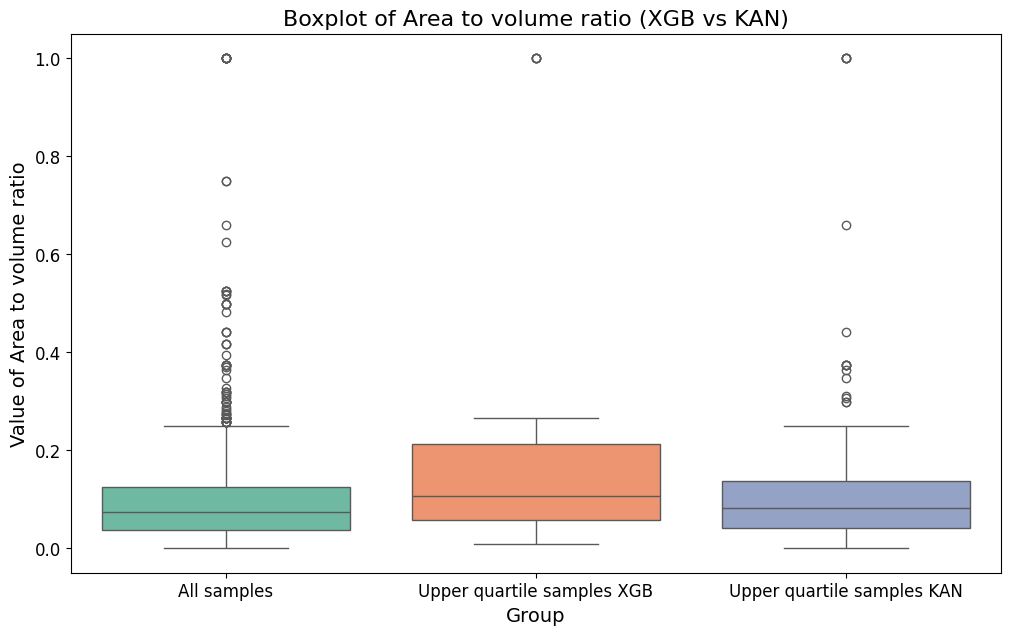

Mann-Whitney U test for Area to volume ratio (XGB): statistic=5843.0000, p-value=0.0190
Mann-Whitney U test for Area to volume ratio (KAN): statistic=80912.5000, p-value=0.2379
Building combined boxplot for Curie temperature (XGB vs KAN)


<ipython-input-37-fb8b2a776c28>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_data, palette='Set2', saturation=0.8)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

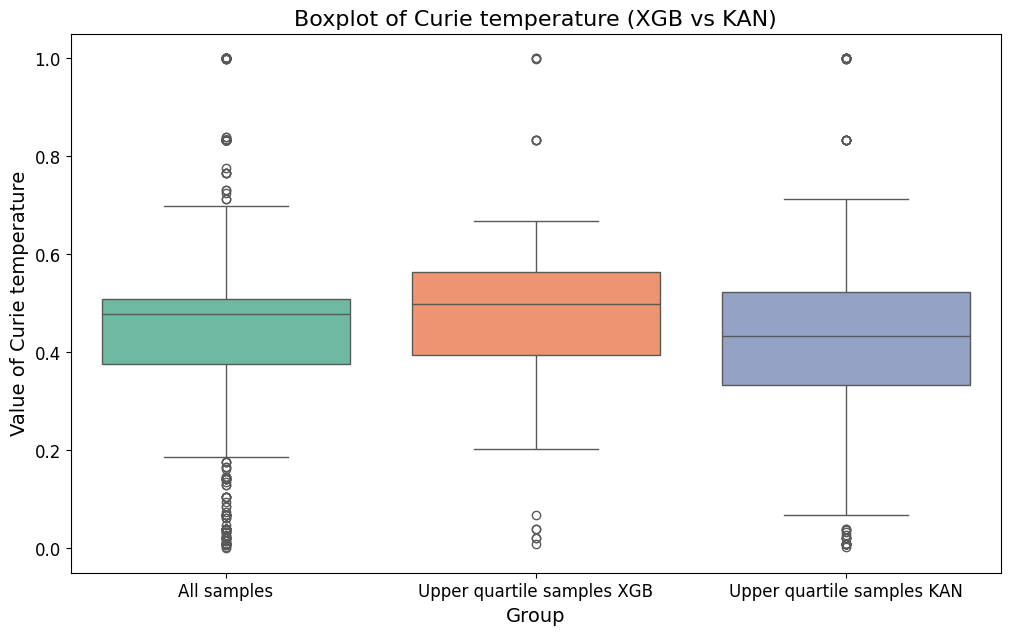

Mann-Whitney U test for Curie temperature (XGB): statistic=5152.5000, p-value=0.4298
Mann-Whitney U test for Curie temperature (KAN): statistic=71349.5000, p-value=0.1281
Building combined boxplot for Valence electron concentration difference of shell (XGB vs KAN)


<ipython-input-37-fb8b2a776c28>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_data, palette='Set2', saturation=0.8)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

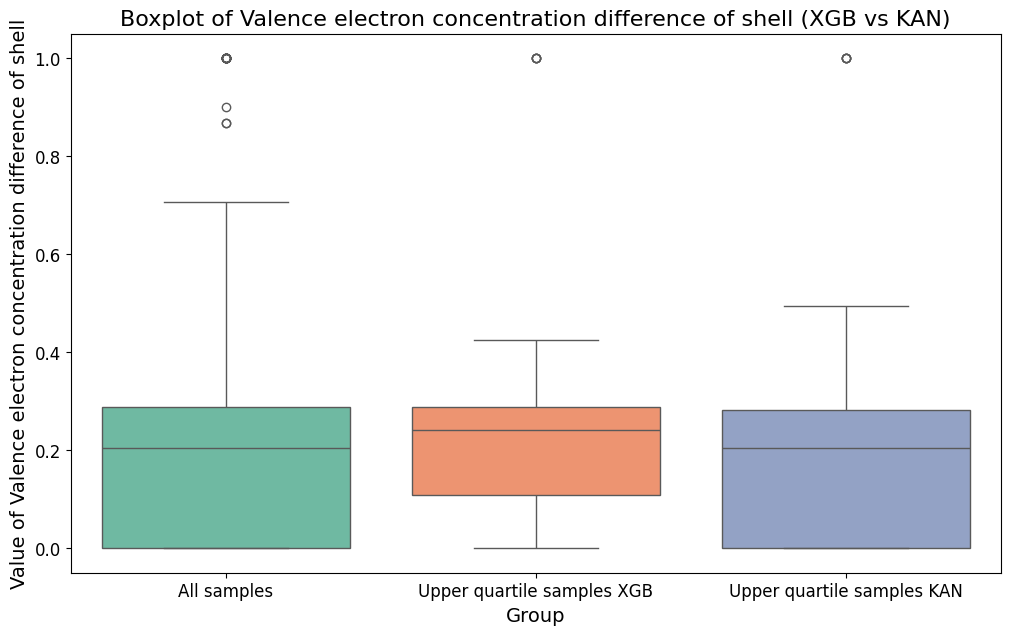

Mann-Whitney U test for Valence electron concentration difference of shell (XGB): statistic=5115.5000, p-value=0.4764
Mann-Whitney U test for Valence electron concentration difference of shell (KAN): statistic=71522.0000, p-value=0.1363
Building combined boxplot for Magnetic field strength (XGB vs KAN)


<ipython-input-37-fb8b2a776c28>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_data, palette='Set2', saturation=0.8)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

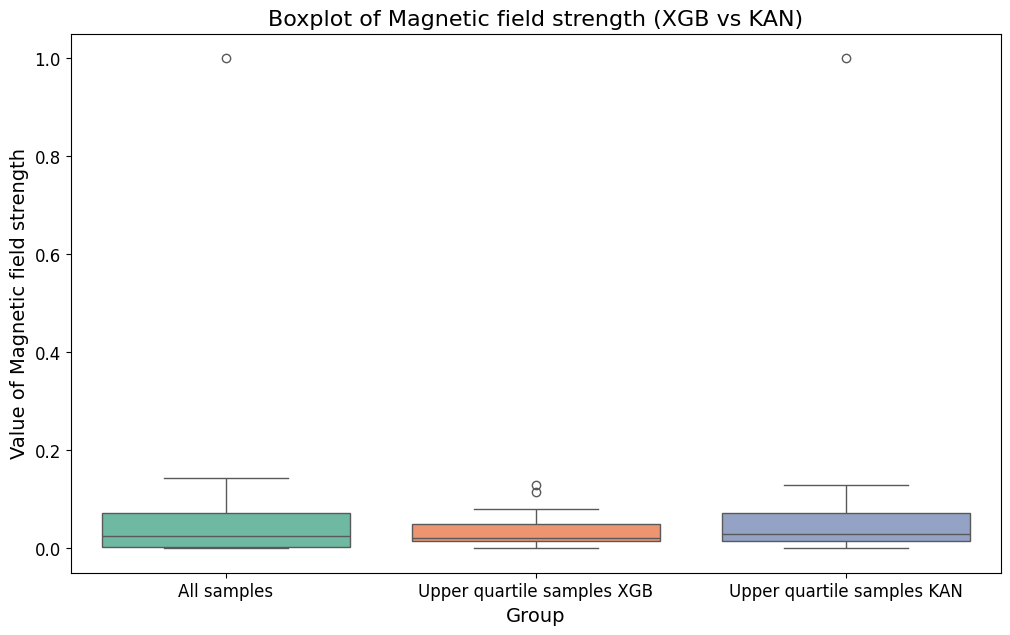

Mann-Whitney U test for Magnetic field strength (XGB): statistic=5326.0000, p-value=0.2357
Mann-Whitney U test for Magnetic field strength (KAN): statistic=88656.5000, p-value=0.0007
Building combined boxplot for Maximum field range (XGB vs KAN)


<ipython-input-37-fb8b2a776c28>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_data, palette='Set2', saturation=0.8)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

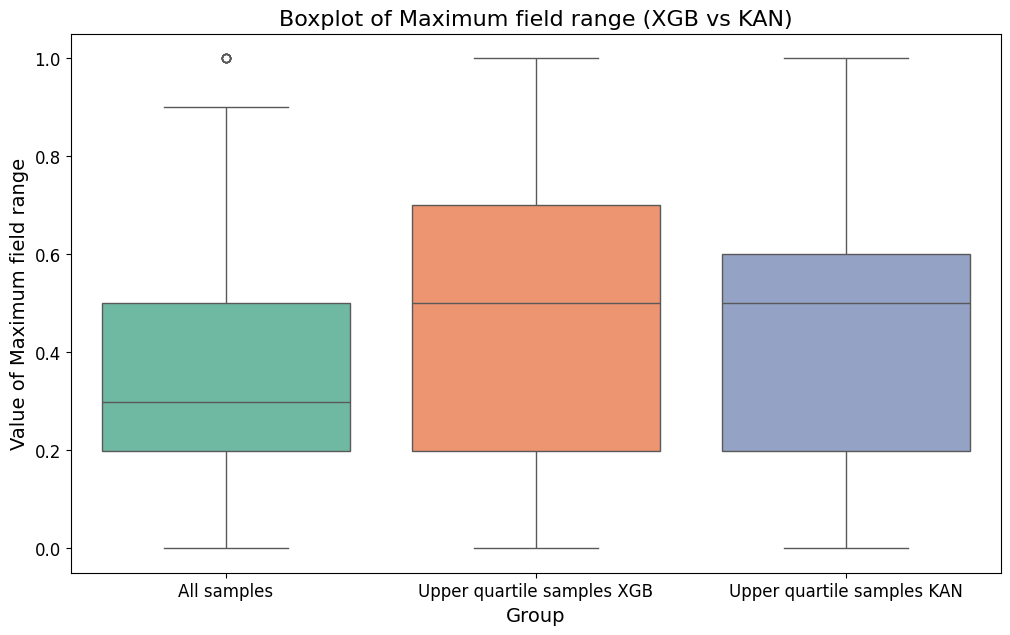

Mann-Whitney U test for Maximum field range (XGB): statistic=5688.5000, p-value=0.0444
Mann-Whitney U test for Maximum field range (KAN): statistic=92355.0000, p-value=0.0000
Building combined boxplot for Core alpha angle (XGB vs KAN)


<ipython-input-37-fb8b2a776c28>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_data, palette='Set2', saturation=0.8)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

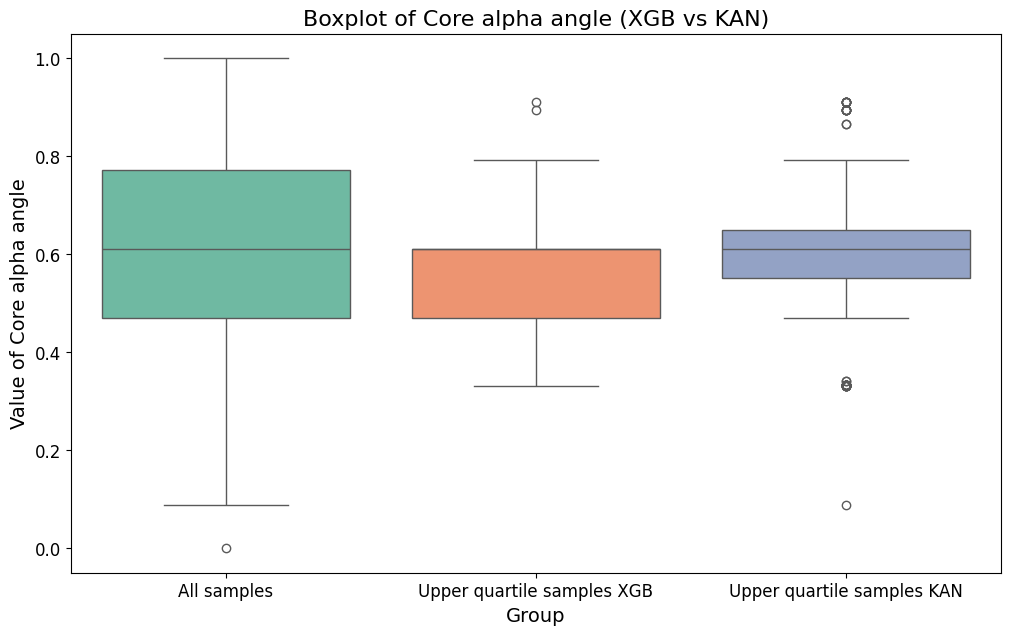

Mann-Whitney U test for Core alpha angle (XGB): statistic=4357.5000, p-value=0.3019
Mann-Whitney U test for Core alpha angle (KAN): statistic=73885.0000, p-value=0.4120
Building combined boxplot for Core beta angle (XGB vs KAN)


<ipython-input-37-fb8b2a776c28>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_data, palette='Set2', saturation=0.8)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

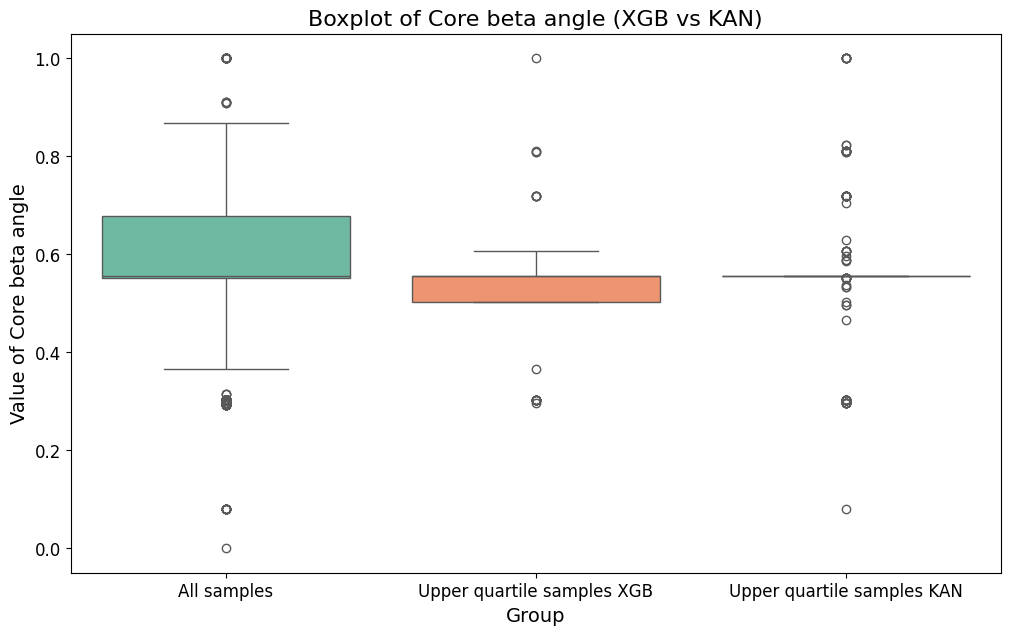

Mann-Whitney U test for Core beta angle (XGB): statistic=4568.0000, p-value=0.5802
Mann-Whitney U test for Core beta angle (KAN): statistic=74500.0000, p-value=0.5108
Building combined boxplot for Core b lattice parameter (XGB vs KAN)


<ipython-input-37-fb8b2a776c28>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_data, palette='Set2', saturation=0.8)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

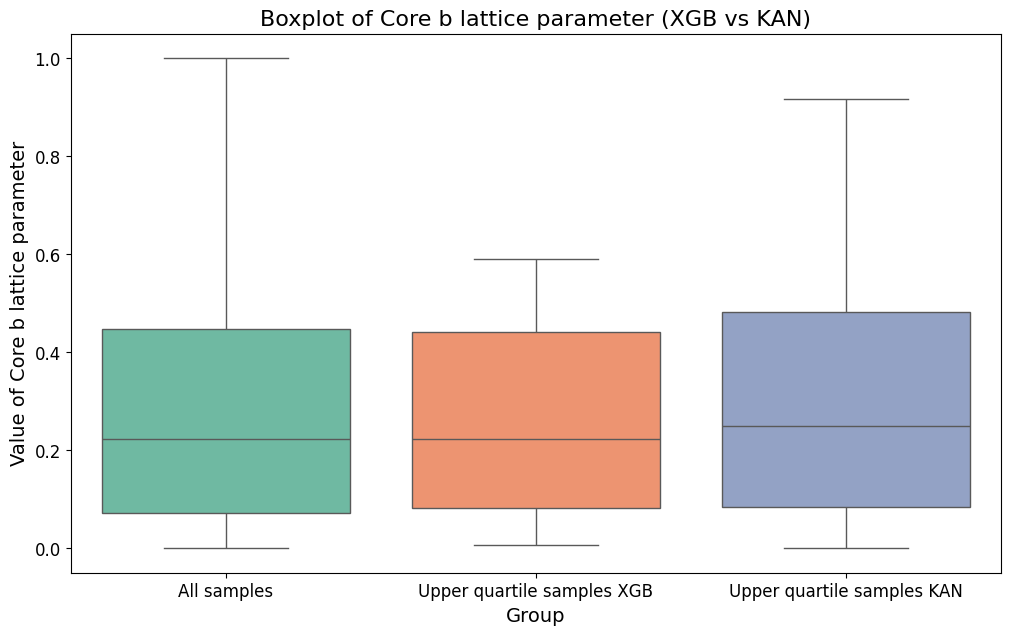

Mann-Whitney U test for Core b lattice parameter (XGB): statistic=4535.5000, p-value=0.5482
Mann-Whitney U test for Core b lattice parameter (KAN): statistic=84880.5000, p-value=0.0212
Building combined boxplot for Shell b lattice parameter (XGB vs KAN)


<ipython-input-37-fb8b2a776c28>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=combined_data, palette='Set2', saturation=0.8)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 t

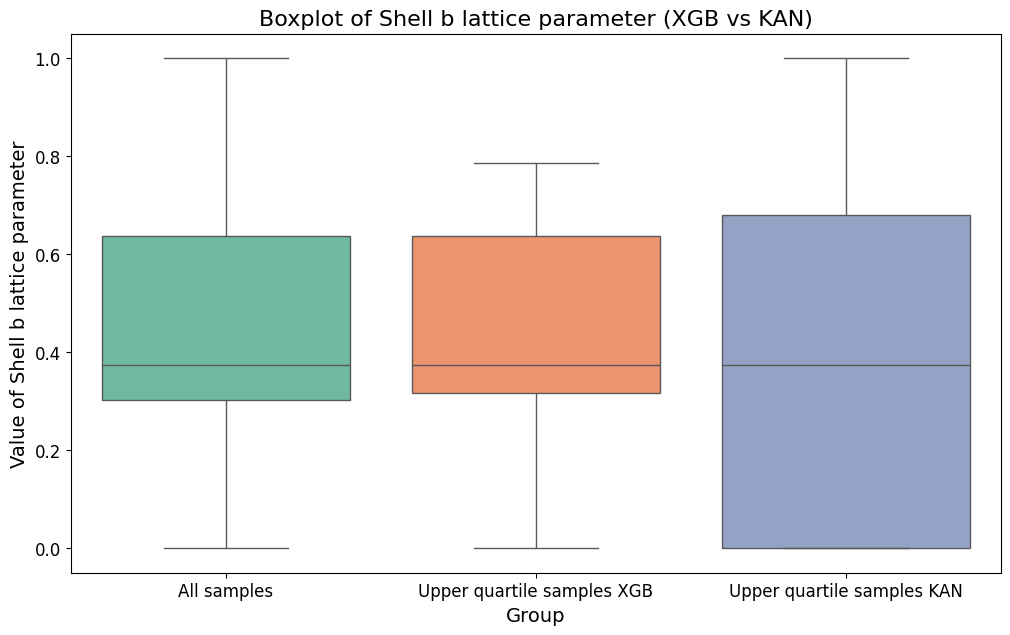

Mann-Whitney U test for Shell b lattice parameter (XGB): statistic=5003.0000, p-value=0.6491
Mann-Whitney U test for Shell b lattice parameter (KAN): statistic=78226.5000, p-value=0.6703

Mann-Whitney U Test Results:
                                              Feature  XGB Statistic  \
0                            Experimental temperature         3899.0   
1                   Pauling electronegativity of core         4298.0   
2                                Area to volume ratio         5843.0   
3                                   Curie temperature         5152.5   
4   Valence electron concentration difference of s...         5115.5   
5                             Magnetic field strength         5326.0   
6                                 Maximum field range         5688.5   
7                                    Core alpha angle         4357.5   
8                                     Core beta angle         4568.0   
9                            Core b lattice parameter         4

In [ ]:
# Function for building boxplots and joining with KAN
def plot_feature_comparison_boxplot_kan(feature, xgb_data):
    # Get data for the upper quartile and all others (KAN)
    upper_quartile_threshold = np.percentile(y_train, 75)
    data_upper_kan = X_train_scaled_df[y_train >= upper_quartile_threshold][feature]
    data_all_kan = X_train_scaled_df[feature]

    # Create DataFrame for KAN
    data_combined_kan = pd.DataFrame({
        'Value': np.concatenate([data_all_kan, data_upper_kan]),
        'Group': ['All samples'] * len(data_all_kan) + ['Upper quartile samples KAN'] * len(data_upper_kan)
    })

    # Combine XGB and KAN data
    combined_data = pd.concat([xgb_data, data_combined_kan])

    # Visualization of distributions via boxplot (XGB and KAN together)
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='Group', y='Value', data=combined_data, palette='Set2', saturation=0.8)
    plt.title(f'Boxplot of {feature} (XGB vs KAN)', fontsize=16)
    plt.xlabel('Group', fontsize=14)
    plt.ylabel(f'Value of {feature}', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    # The Manna-Whitney statistical test for KAN and XGB separately
    stat_xgb, p_value_xgb = stats.mannwhitneyu(
        xgb_data['Value'][xgb_data['Group'] == 'Upper quartile samples XGB'],
        xgb_data['Value'][xgb_data['Group'] == 'All samples']
    )
    stat_kan, p_value_kan = stats.mannwhitneyu(
        data_combined_kan['Value'][data_combined_kan['Group'] == 'Upper quartile samples KAN'],
        data_combined_kan['Value'][data_combined_kan['Group'] == 'All samples']
    )

    # Adding results to list
    results.append({
        'Feature': feature,
        'XGB Statistic': stat_xgb,
        'XGB p-value': p_value_xgb,
        'KAN Statistic': stat_kan,
        'KAN p-value': p_value_kan
    })

    print(f'Mann-Whitney U test for {feature} (XGB): statistic={stat_xgb:.4f}, p-value={p_value_xgb:.4f}')
    print(f'Mann-Whitney U test for {feature} (KAN): statistic={stat_kan:.4f}, p-value={p_value_kan:.4f}')

# Plotting of intersecting features with the combination of XGB and KAN
for feature in common_features:
    print(f'Building combined boxplot for {feature} (XGB vs KAN)')
    plot_feature_comparison_boxplot_kan(feature, xgb_distributions[feature])

# Create DataFrame for results
results_df = pd.DataFrame(results)

# Display results
print("\nMann-Whitney U Test Results:")
print(results_df)

## violin plots

Building combined violin plots for all features (XGB vs KAN)


<ipython-input-50-897d200de498>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Value', data=combined_data, palette='Set2', inner=None, scale='area')
<ipython-input-50-897d200de498>:34: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  sns.violinplot(x='Group', y='Value', data=combined_data, palette='Set2', inner=None, scale='area')
<ipython-input-50-897d200de498>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Value', data=combined_data, palette='Set2', inner=None, scale='area')
<ipython-input-50-897d200de498>:34: FutureWarning: 

The `scale` parameter has been ren

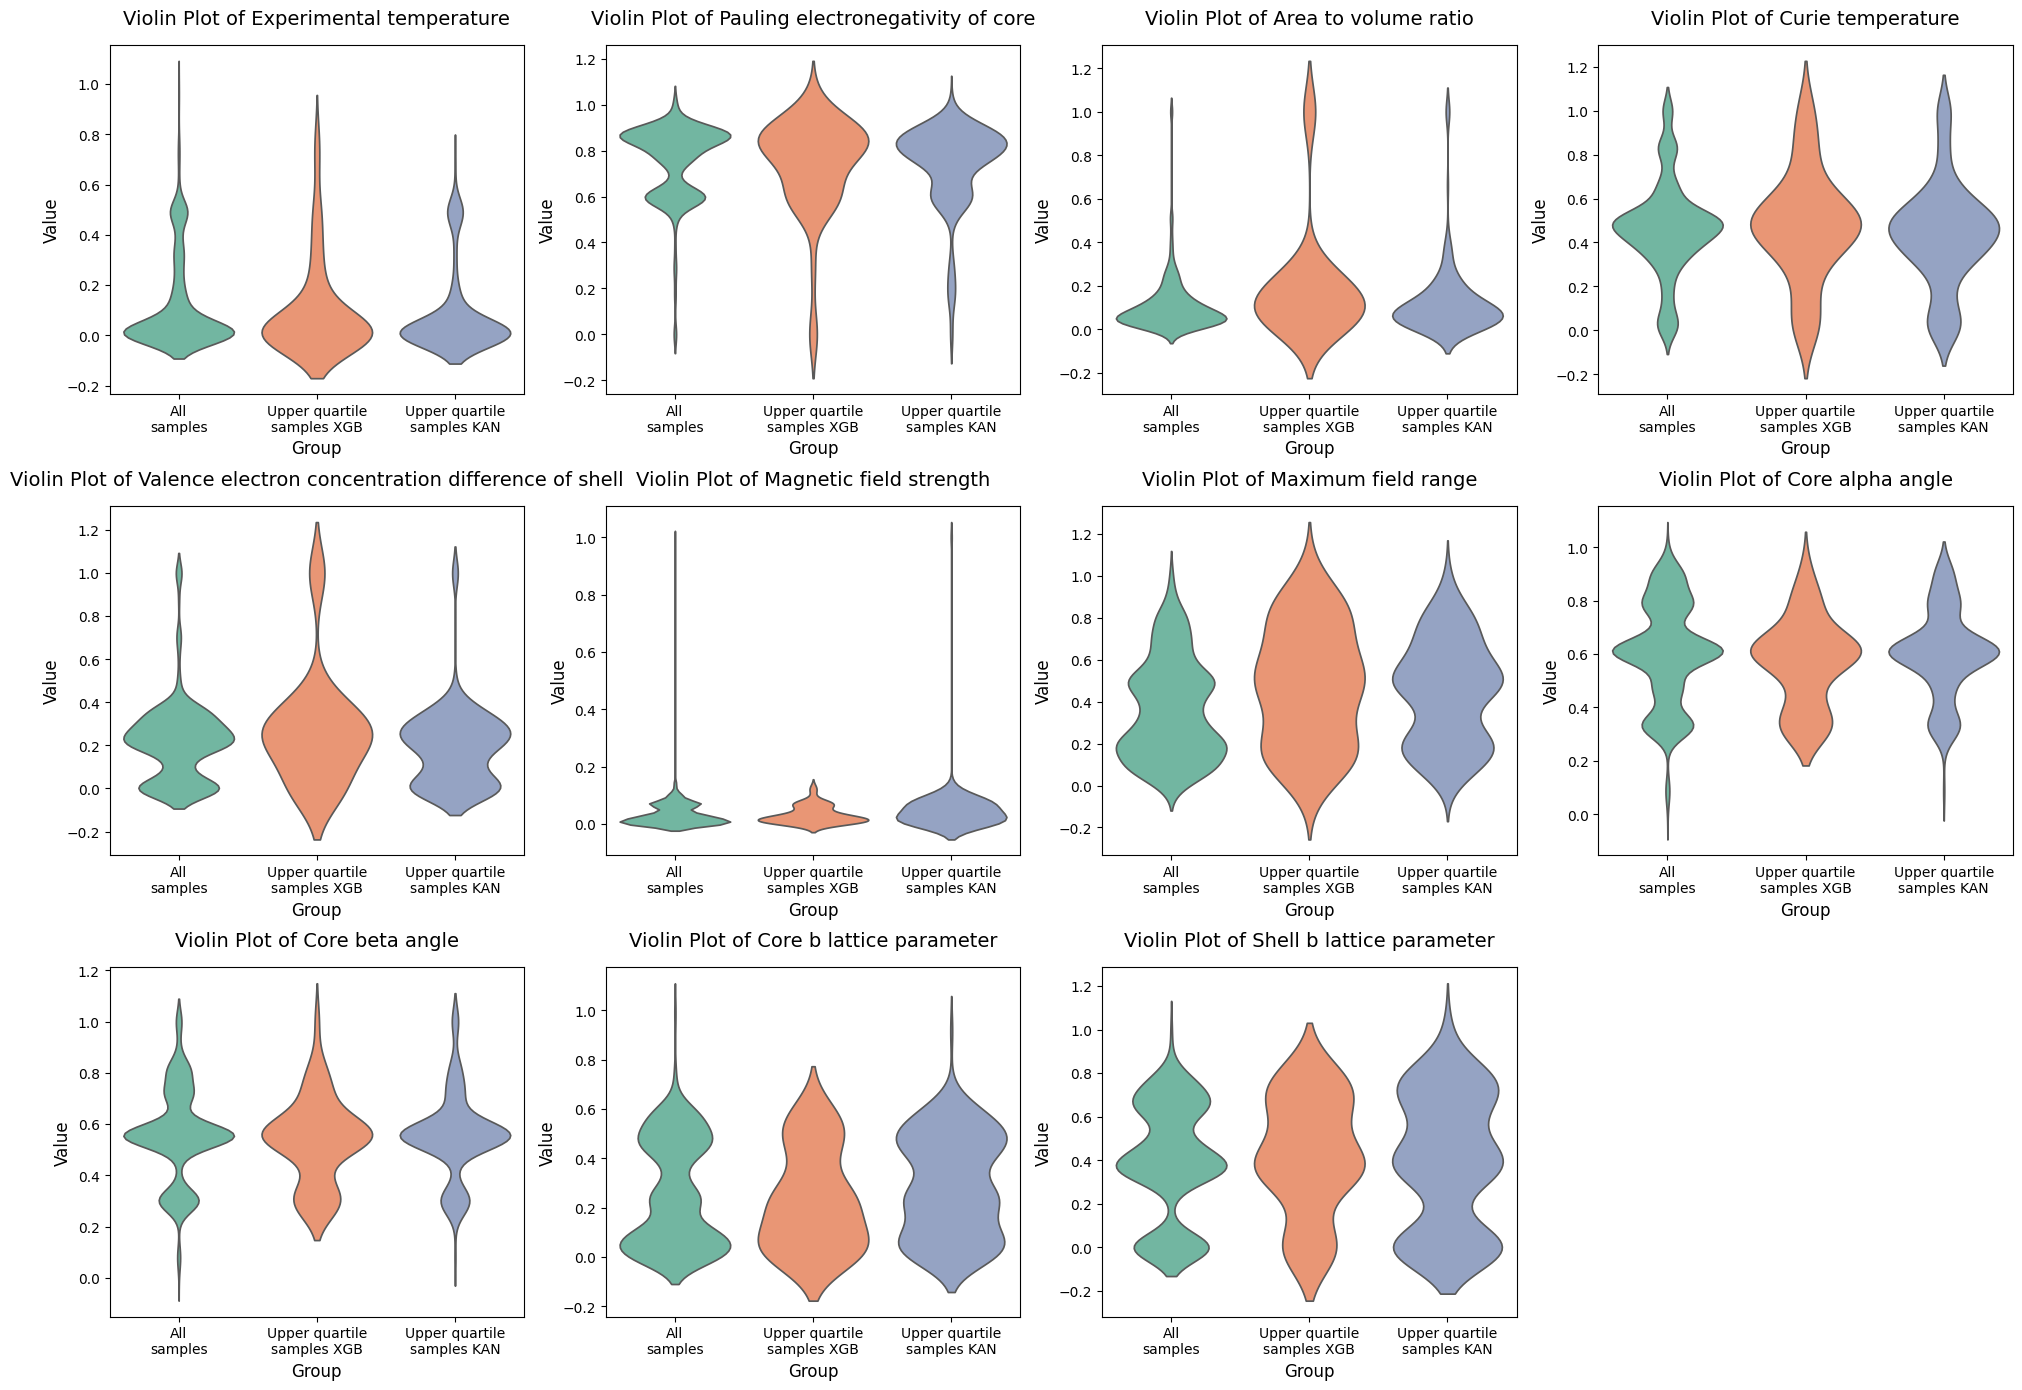

In [ ]:
# Function to create a combined violin plot for all features
def plot_combined_violin_kan(features, xgb_distributions):
    num_features = len(features)
    ncols = 4  # Number of columns in the subplot grid
    nrows = (num_features + ncols - 1) // ncols  # Calculate number of rows needed

    plt.figure(figsize=(20, 5 * nrows))  # Set the overall figure size

    for i, feature in enumerate(features):
        plt.subplot(nrows, ncols, i + 1)  # Create a subplot for each feature

        # Get KAN data
        upper_quartile_threshold = np.percentile(y_train, 75)
        data_upper_kan = X_train_scaled_df[y_train >= upper_quartile_threshold][feature]
        data_all_kan = X_train_scaled_df[feature]

        # Create DataFrame for KAN
        data_combined_kan = pd.DataFrame({
            'Value': np.concatenate([data_all_kan, data_upper_kan]),
            'Group': ['All samples'] * len(data_all_kan) + ['Upper quartile samples KAN'] * len(data_upper_kan)
        })

        # Merge XGB and KAN data
        combined_data = pd.concat([xgb_distributions[feature], data_combined_kan])

        # Modify group labels to be on two lines
        combined_data['Group'] = combined_data['Group'].replace({
            'All samples': 'All\nsamples',
            'Upper quartile samples KAN': 'Upper quartile\nsamples KAN',
            'Upper quartile samples XGB': 'Upper quartile\nsamples XGB'
        })

        # Visualize distributions through a violin plot (XGB and KAN together)
        sns.violinplot(x='Group', y='Value', data=combined_data, palette='Set2', inner=None, scale='area')

        # Adjust title and labels
        plt.title(f'Violin Plot of {feature}', fontsize=14, pad=15)  # Move title lower with pad
        plt.xlabel('Group', fontsize=12)
        plt.ylabel('Value', fontsize=12)

        # Keep x-axis labels straight (no rotation)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent overlap
    plt.subplots_adjust(top=0.9)  # Further adjust the top space for titles
    plt.show()

# Call the function to create the combined violin plot for all features
print("Building combined violin plots for all features (XGB vs KAN)")
plot_combined_violin_kan(common_features, xgb_distributions)

In [ ]:
# Сохранение результатов в файл CSV
results_df.to_csv('mann_whitney_test_results.csv', index=False)

print("Results have been saved to 'mann_whitney_test_results.csv'")

Results have been saved to 'mann_whitney_test_results.csv'


### Only those parameters that have p<0.05

Building combined violin plots for selected features (XGB vs KAN)


<ipython-input-53-e56ffa021071>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Value', data=combined_data, palette='Set2', inner=None, scale='area')
<ipython-input-53-e56ffa021071>:40: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  sns.violinplot(x='Group', y='Value', data=combined_data, palette='Set2', inner=None, scale='area')
<ipython-input-53-e56ffa021071>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Value', data=combined_data, palette='Set2', inner=None, scale='area')
<ipython-input-53-e56ffa021071>:40: FutureWarning: 

The `scale` parameter has been ren

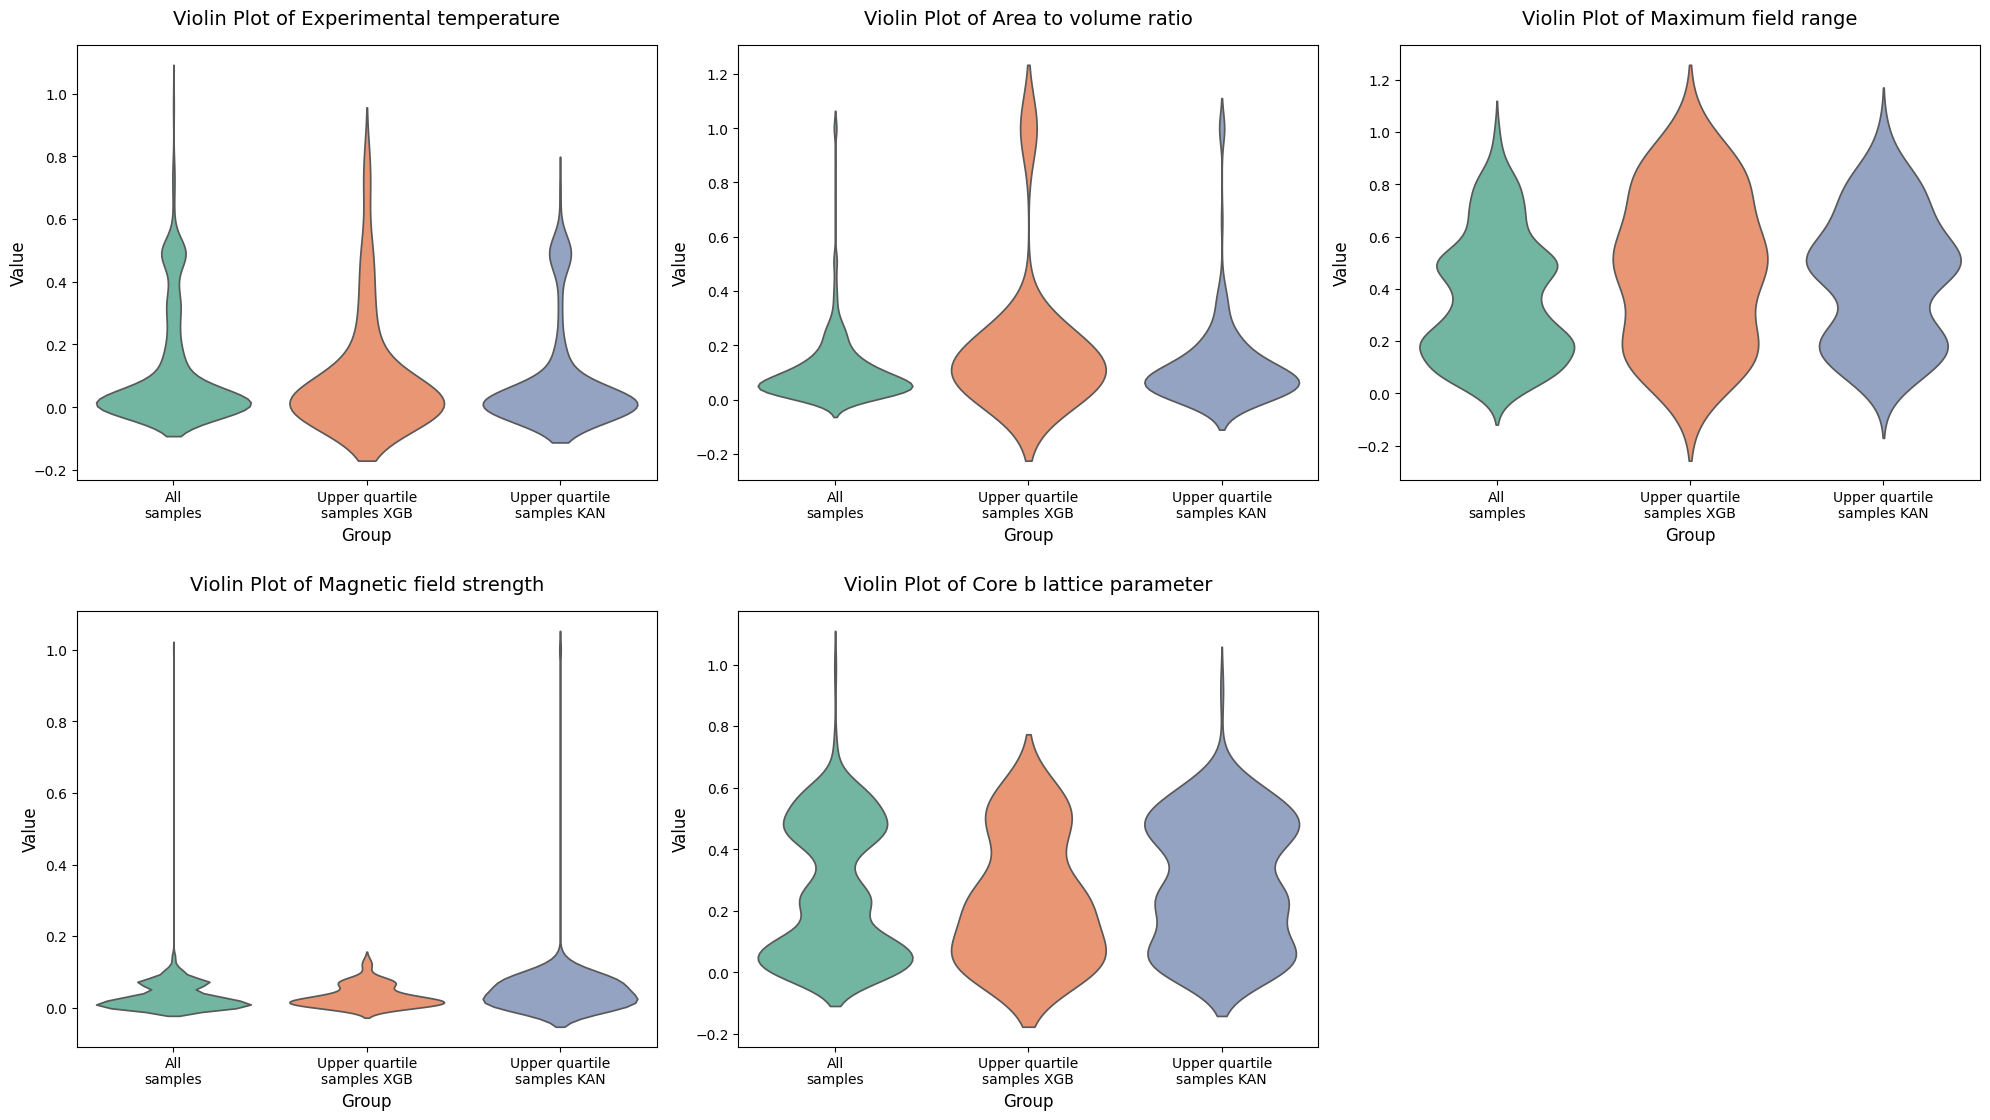

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create a combined violin plot for selected features
def plot_combined_violin_kan(selected_features, xgb_distributions):
    num_features = len(selected_features)
    ncols = 3  # Number of columns in the subplot grid
    nrows = (num_features + ncols - 1) // ncols  # Calculate number of rows needed

    # Increase the height of each subplot by adjusting the figsize
    plt.figure(figsize=(20, 6 * nrows))  # Set the overall figure size with increased height

    for i, feature in enumerate(selected_features):
        plt.subplot(nrows, ncols, i + 1)  # Create a subplot for each feature

        # Get KAN data
        upper_quartile_threshold = np.percentile(y_train, 75)
        data_upper_kan = X_train_scaled_df[y_train >= upper_quartile_threshold][feature]
        data_all_kan = X_train_scaled_df[feature]

        # Create DataFrame for KAN
        data_combined_kan = pd.DataFrame({
            'Value': np.concatenate([data_all_kan, data_upper_kan]),
            'Group': ['All samples'] * len(data_all_kan) + ['Upper quartile samples KAN'] * len(data_upper_kan)
        })

        # Merge XGB and KAN data
        combined_data = pd.concat([xgb_distributions[feature], data_combined_kan])

        # Modify group labels to be on two lines
        combined_data['Group'] = combined_data['Group'].replace({
            'All samples': 'All\nsamples',
            'Upper quartile samples KAN': 'Upper quartile\nsamples KAN',
            'Upper quartile samples XGB': 'Upper quartile\nsamples XGB'
        })

        # Visualize distributions through a violin plot (XGB and KAN together)
        sns.violinplot(x='Group', y='Value', data=combined_data, palette='Set2', inner=None, scale='area')

        # Adjust title and labels
        plt.title(f'Violin Plot of {feature}', fontsize=14, pad=15)  # Move title lower with pad
        plt.xlabel('Group', fontsize=12)
        plt.ylabel('Value', fontsize=12)

        # Keep x-axis labels straight (no rotation)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent overlap
    plt.subplots_adjust(top=0.9, hspace=0.3)  # Further adjust the top space for titles and vertical spacing
    plt.show()

# List of features to include in the plot
selected_features = [
    "Experimental temperature",
    "Area to volume ratio",
    "Maximum field range",
    "Magnetic field strength",
    "Core b lattice parameter"
]

# Call the function to create the combined violin plot for the selected features
print("Building combined violin plots for selected features (XGB vs KAN)")
plot_combined_violin_kan(selected_features, xgb_distributions)